
<h1><center>Google Analytics Customer Revenue Prediction</center></h1>

_____________

## 1. Business probelm:

### 1.1 Description:
<br>
<br>
Source: https://www.kaggle.com/c/ga-customer-revenue-prediction

Data: Provided by google for kaggle competition

Download ga-customer-revenue-prediction.zip from Kaggle.
<br>
<br>
###### Problem statement  :

 - In every business it was proven about 80-20 rule., this rule tells us 80%  of our revenue will be generated by only 20% of our potential customers. So our goal is to predict the revenue that is going to be generated by those potential customers in the near feature. So that marketing teams will invest appropriate money on promotional strategies to attract potential customers.
 - In simple words we are given with the users past data and transactions  (when they logged into Gstore)., so by using this data we need to predict the future revenue will be created by those customers.
 - So google provided Merchandise customer dataset and no.of transactions per customer. We will build a predictive model using Gstore data set to predict the total revenue per customer that helps in better use of marketing budget and we will also interpret the most impacting element on the total revenue prediction using different models.
 
<br>
<br>

### 1.2. Source/Useful Links:

 - https://www.youtube.com/watch?v=g6ZsaNmtIww&t=536s
 - https://www.kaggle.com/c/ga-customer-revenue-prediction/discussion/68353
 - https://medium.com/@jacky308082/this-time-i-would-try-to-use-english-to-explain-this-whole-project-4a26c9294ccf
 - https://www.kaggle.com/c/ga-customer-revenue-prediction/discussion/82614

<br>
<br>

### 1.3. Real-world/Business objectives and constraints:

 - No low-latency requirement.
 - only a very small percentage of customers produce most of the revenue., so we need to carefully analyze the revenue generated by customers.

    

___________________

## 2. Machine Learning Problem Formulation

### 2.1. Data:

### 2.1.1. Data Overview:
 - source: https://www.kaggle.com/c/ga-customer-revenue-prediction/data
 - we need to download train_v2.csv and test_v2.csv
 - we will be predicting the target for all users in the posted test set: test_v2.csv, for their transactions in the future time period of December 1st 2018 through January 31st 2019.
 - Each row in the dataset is one visit to the store. Because we are predicting the log of the total revenue per user, not all rows in test.csv will correspond to a row in the submission, but all unique fullVisitorIds will correspond to a row in the submission.
 - some of the features are in json format so we need to parse those json columns., regarding this we will see in brief at the time of data reading
 
<br>

#### Data fields:

 - fullVisitorId- A unique identifier for each user of the Google Merchandise Store.

 - channelGrouping - The channel via which the user came to the Store.

 - date - The date on which the user visited the Store.

 - device - The specifications for the device used to access the Store.

 - geoNetwork - This section contains information about the geography of the user.

 - sessionId - A unique identifier for this visit to the store.

 - socialEngagementType - Engagement type, either “Socially Engaged” or “Not Socially Engaged”.

 - totals - This section contains aggregate values across the session.

 - trafficSource - This section contains information about the Traffic Source from which the session originated.

 - visitId - An identifier for this session. This is part of the value usually stored as the utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.

 - visitNumber - The session number for this user. If this is the first session, then this is set to 1.

 - visitStartTime - The timestamp (expressed as POSIX time).
 
features desciption:
 - https://support.google.com/analytics/answer/3437719?hl=en
 

## 2.2. Mapping the real-world problem to an ML problem:

### 2.2.1. Type of Machine Learning Problem:
 - so here we are going to predict the revenue generated by the cusotmer (in dollars) when he visits the store ., so we can pose this problem as regression problem
 - By follwing some of the kaggle discussions and winners solution., they are solving this problem in this way.
    - they are building a classification model that will predict whether the user will visit the store or not in the test peroid time and then suppose if there is chnace that he is visting store then by using regression model we will predict the revenue is going to be generated by the cusomer.
 - Solving the problem as Classification + Regression is motivated by Hurdle Model(https://seananderson.ca/2014/05/18/gamma-hurdle/). 
  
    ###### Hurdle Model :-

  - This model is preferred way of solving problem where target variable has more number of zeroes than a value.
  
  - It recommends to solve problem by 
             - Classification whether the value is going to non-zero or not
             - And then predict the amount.
  The solution implemented for this challenge is based on above model.
  <br>
  
 - anyway we will discuss more about this at the time of featurization and model building.
<br>
<br>

### 2.2.2. Performance Metric:
 - We are predicting the natural log of the sum of all transactions per user.
 - so the right metirc for regresion problems is RMSE. so even kaggle also given evalution metric as RMSE.
 - transaction_of_user_i = log(1+ all transactions of user_i)

## 2.3. Train and Test Datasets:

 - train data : transactions from Aug 1st 2016 to April 30th 2018
 - test  data : transactions from May 1st 2018 to Octob 15th 2018
 - kaggle private leader board prediction data : Dec 1st 2018 to jan 31 st 2019

_________

________ 

## 3. Data loading and preprocessing:

In [ ]:
import os
import time
import warnings
warnings.filterwarnings('ignore')

# basic libraries for reading data and plotting:
#------------------------------
import pandas as pd
import dask.dataframe as dd
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import json
from pandas.io.json import json_normalize #package for flattening json in pandas df

# models,scoring, hyperparameter tuning libraries:
# --------------------------------------
from sklearn import linear_model
from sklearn.linear_model import SGDRegressor
import lightgbm as lgb # Light GBM model
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

# from mlxtend.classifier import StackingClassifier

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from random import random
from random import randrange


#feature importance:
#from yellowbrick.model_selection import RFECV

#for results table:
from prettytable import PrettyTable
from IPython.display import Image




   - json_normalize:
 - Normalize semi-structured JSON data into a flat table.
   - json.loads:
 - take string as an input and create a json object with the specified string as object name

https://towardsdatascience.com/why-and-how-to-use-pandas-with-large-data-9594dda2ea4c

In [ ]:
# credits : https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields

def load_df(csv_path, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource'] # we are definig a list of json column names

    df = pd.read_csv(csv_path,
                     converters={
                         column: json.loads for column in JSON_COLUMNS}, # It will create JSON object for every json column
                     dtype={'fullVisitorId': 'str'},  # we are considering 'fullvisitor id as string'
                     nrows=nrows)

    for column in tqdm(JSON_COLUMNS):
        column_as_df = json_normalize(df[column]) # json_normalize will return a flatten dataframe of json columns
        
        column_as_df.columns = ["{0}.{1}".format(column, subcolumn) for subcolumn in column_as_df.columns] # we are taking  
                                                                                                           # column names
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True) # we are dropping json column and
                                                                                            # and merging data frame with parsed columns
        
    print("Loaded {0}. Shape: {1}".format(os.path.basename(csv_path), df.shape))
    
    return df


In [ ]:
%%time 
train_df = load_df("train_v2.csv")

100%|██████████| 4/4 [02:39<00:00, 39.98s/it]

Loaded train_v2.csv. Shape: (1708337, 60)
CPU times: user 6min 1s, sys: 29.7 s, total: 6min 31s
Wall time: 6min 31s


In [ ]:
train_df

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,...,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.referralPath,trafficSource.isTrueDirect,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.campaignCode
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,Firefox,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,Chrome,...,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508201613,1,1508201613,Chrome,...,not available in demo dataset,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,9075655783635761930,"[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,1508169851,1,1508169851,Chrome,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,6960673291025684308,"[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,1508190552,1,1508190552,Chrome,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1708332,Social,[],20170104,5123779100307500332,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1483554750,1,1483554750,Chrome,...,not available in demo dataset,/yt/about/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1708333,Social,[],20170104,7231728964973959842,"[{'hitNumber': '1', 'time': '0', 'hour': '7', ...",Not Socially Engaged,1483543798,1,1483543798,Chrome,...,not available in demo dataset,/yt/about/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1708334,Social,[],20170104,5744576632396406899,"[{'hitNumber': '1', 'time': '0', 'hour': '2', ...",Not Socially Engaged,1483526434,1,1483526434,Android Webview,...,not available in demo dataset,/yt/about/ko/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1708335,Social,"[{'index': '4', 'value': 'APAC'}]",20170104,2709355455991750775,"[{'hitNumber': '2', 'time': '0', 'hour': '21',...",Not Socially Engaged,1483592857,1,1483592864,Chrome,...,not available in demo dataset,/l.php,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train_df.shape

(1708337, 60)

In [ ]:
train_df.to_csv('train_df.csv')

In [ ]:
%%time
test_df  = load_df("test_v2.csv")

100%|██████████| 4/4 [00:42<00:00, 10.61s/it]

Loaded test_v2.csv. Shape: (401589, 59)
CPU times: user 1min 42s, sys: 6.2 s, total: 1min 48s
Wall time: 2min 38s


In [ ]:
test_df.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,...,trafficSource.medium,trafficSource.keyword,trafficSource.adContent,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd
0,Organic Search,"[{'index': '4', 'value': 'APAC'}]",20180511,7460955084541987166,"[{'hitNumber': '1', 'time': '0', 'hour': '21',...",Not Socially Engaged,1526099341,2,1526099341,Chrome,...,organic,(not provided),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
1,Direct,"[{'index': '4', 'value': 'North America'}]",20180511,460252456180441002,"[{'hitNumber': '1', 'time': '0', 'hour': '11',...",Not Socially Engaged,1526064483,166,1526064483,Chrome,...,(none),(not set),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
2,Organic Search,"[{'index': '4', 'value': 'North America'}]",20180511,3461808543879602873,"[{'hitNumber': '1', 'time': '0', 'hour': '12',...",Not Socially Engaged,1526067157,2,1526067157,Chrome,...,organic,(not provided),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
3,Direct,"[{'index': '4', 'value': 'North America'}]",20180511,975129477712150630,"[{'hitNumber': '1', 'time': '0', 'hour': '23',...",Not Socially Engaged,1526107551,4,1526107551,Chrome,...,(none),(not set),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
4,Organic Search,"[{'index': '4', 'value': 'North America'}]",20180511,8381672768065729990,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1526060254,1,1526060254,Internet Explorer,...,organic,(not provided),(not set),NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN


In [ ]:
test_df.shape

(401589, 59)

In [ ]:
test_df.to_csv('test_df.csv')

In [ ]:
# storing data frames as csv files:
#train_df.to_csv('case study data/train_df.csv')
#test_df.to_csv('case study data/test_df.csv')

# reading from files
# train_df = pd.read_csv('train_df.csv',dtype={'fullVisitorId': 'str'},index_col=0)
# test_df = pd.read_csv('test_df.csv',dtype={'fullVisitorId': 'str'},index_col=0)

In [ ]:
%%time
train_df = pd.read_csv('train_df.csv',dtype={'fullVisitorId': 'str'},index_col=0)

CPU times: user 2min 51s, sys: 21.3 s, total: 3min 12s
Wall time: 3min 34s


In [ ]:
%%time
test_df = pd.read_csv('test_df.csv',dtype={'fullVisitorId': 'str'},index_col=0)

CPU times: user 51.5 s, sys: 7.76 s, total: 59.3 s
Wall time: 59.2 s


In [ ]:
print(train_df.shape)
print(test_df.shape)

(1708337, 60)
(401589, 59)


In [ ]:
# we will check how many unique values are present in each column of data:
train_df.nunique()

channelGrouping                                            8
customDimensions                                           6
date                                                     638
fullVisitorId                                        1323730
hits                                                 1338924
socialEngagementType                                       1
visitId                                              1665802
visitNumber                                              457
visitStartTime                                       1667423
device.browser                                           129
device.browserVersion                                      1
device.browserSize                                         1
device.operatingSystem                                    24
device.operatingSystemVersion                              1
device.isMobile                                            2
device.mobileDeviceBranding                                1
device.mobileDeviceModel

In [ ]:
test_df.nunique()

channelGrouping                                           8
customDimensions                                          6
date                                                    168
fullVisitorId                                        296530
hits                                                 345893
socialEngagementType                                      1
visitId                                              393181
visitNumber                                             386
visitStartTime                                       393643
device.browser                                           62
device.browserVersion                                     1
device.browserSize                                        1
device.operatingSystem                                   22
device.operatingSystemVersion                             1
device.isMobile                                           2
device.mobileDeviceBranding                               1
device.mobileDeviceModel                

____________

 - observation: if the same unique value present in all rows of any given feature means no need to use those features. since that feature value is constant across all records means it won't affect our final predicting variable.

In [ ]:
# so here we will drop those columns which will have unique value acorss all records or rows :

columns = train_df.columns.to_list()

unique_columns=[]

for column in columns:
    count = train_df[column].nunique()
    if count==1:
        del train_df[column]
        unique_columns.append(column)

In [ ]:
train_df.shape

(1708337, 36)

In [ ]:
# so here we will drop those columns which will have unique value acorss all records or rows :

test_columns = test_df.columns.to_list()

unique_columns_test=[]

for column in test_columns:
    count = test_df[column].nunique()
    if count==1:
        del test_df[column]
        unique_columns_test.append(column)

In [ ]:
test_df.shape

(401589, 36)

____________

#### Missing data analysis:

In [ ]:
# credits: https://stackoverflow.com/questions/51070985/find-out-the-percentage-of-missing-values-in-each-column-in-the-given-dataset

## Here we are checking in each colummn how much percentage of data missed:

percent_missing = train_df.isnull().sum() * 100 / len(train_df)  #{ (total nulls in particular column*100)/total no.of rows }
missing_value_df = pd.DataFrame({'column_name': train_df.columns,
                                 'percent_missing': percent_missing})

missing_value_df

,column_name,percent_missing
channelGrouping,channelGrouping,0.000000
customDimensions,customDimensions,0.000000
date,date,0.000000
fullVisitorId,fullVisitorId,0.000000
hits,hits,0.000000
visitId,visitId,0.000000
visitNumber,visitNumber,0.000000
visitStartTime,visitStartTime,0.000000
device.browser,device.browser,0.000000
device.operatingSystem,device.operatingSystem,0.000000


In [ ]:
# credits: https://stackoverflow.com/questions/51070985/find-out-the-percentage-of-missing-values-in-each-column-in-the-given-dataset

## Here we are checking in each colummn how much percentage of data missed:

percent_missing_t = test_df.isnull().sum() * 100 / len(test_df)  #{ (total nulls in particular column*100)/total no.of rows }
missing_value_df_t = pd.DataFrame({'column_name': test_df.columns,
                                 'percent_missing': percent_missing_t})

missing_value_df_t

,column_name,percent_missing
channelGrouping,channelGrouping,0.000000
customDimensions,customDimensions,0.000000
date,date,0.000000
fullVisitorId,fullVisitorId,0.000000
hits,hits,0.000000
visitId,visitId,0.000000
visitNumber,visitNumber,0.000000
visitStartTime,visitStartTime,0.000000
device.browser,device.browser,0.000000
device.operatingSystem,device.operatingSystem,0.000000


In [ ]:
train_df['totals.pageviews'].nunique(),test_df['totals.pageviews'].nunique()

(230, 155)

In [ ]:
train_df['totals.pageviews'].fillna(0, inplace=True)
test_df['totals.pageviews'].fillna(0, inplace=True)

In [ ]:
train_df['totals.timeOnSite']

0             NaN
1            28.0
2            38.0
3             1.0
4            52.0
            ...  
1708332     626.0
1708333     258.0
1708334     991.0
1708335    1274.0
1708336    2653.0
Name: totals.timeOnSite, Length: 1708337, dtype: float64

 - Numerical features missing:   
   - totals.pageviews: 0.013
   - totals.timeOnSite: 51.17
   - totals.transactions: 98.91 

In [ ]:
test_df['totals.timeOnSite'].unique()

array([ 973.,   49.,   24., ..., 4647., 3645., 5456.])

<AxesSubplot:xlabel='column_name'>

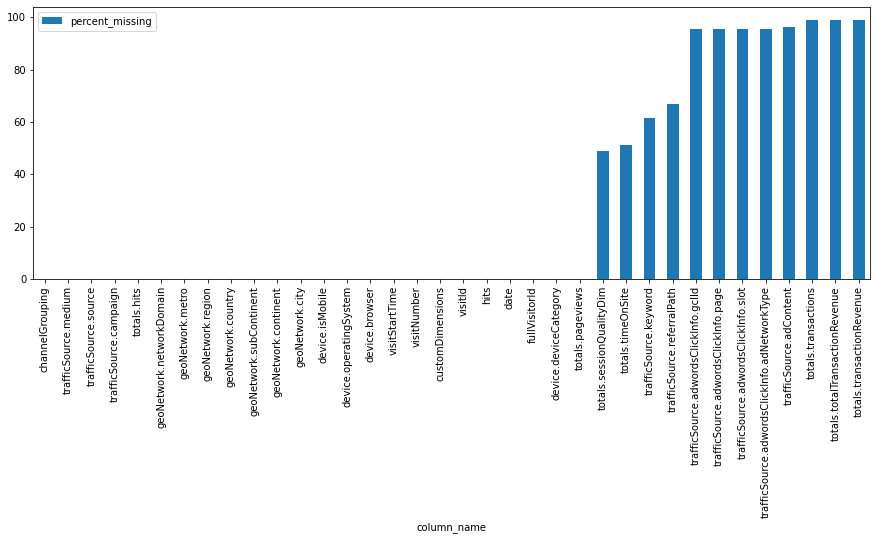

In [ ]:
# we will  obersve the above missing values data by plotting:

missing_value_df.sort_values("percent_missing").plot(kind='bar',x='column_name',y='percent_missing',figsize=(15, 5))

<AxesSubplot:xlabel='column_name'>

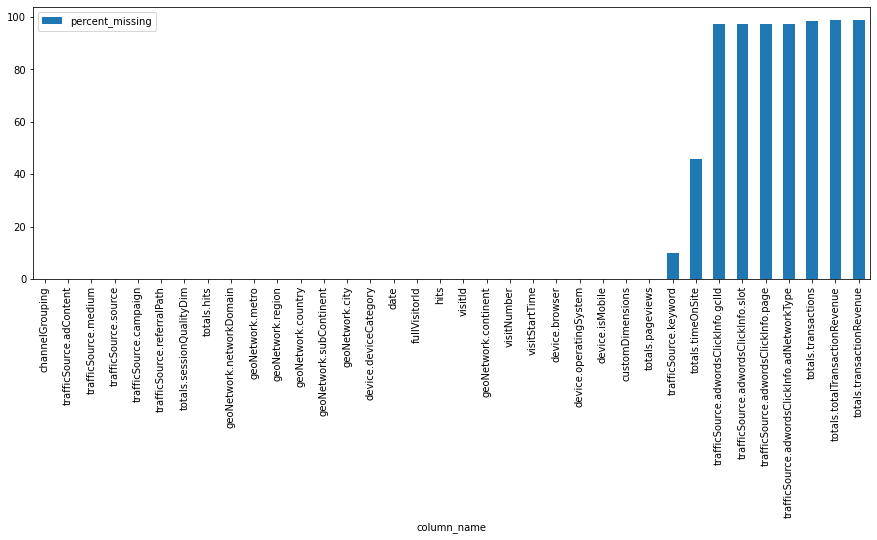

In [ ]:
# we will  obersve the above missing values data by plotting:

missing_value_df_t.sort_values("percent_missing").plot(kind='bar',x='column_name',y='percent_missing',figsize=(15, 5))

<br>
<br>

##### Now we will analyse the each missing valued feature whether it is useful or not ., if it is useful then we will analyse how to impute missing values.

 - totals.sessionQualityDim:
 <br>
An estimate of how close a particular session was to transacting, ranging from 1 to 100, calculated for each session. A value closer to 1 indicates a low session quality, or far from transacting, while a value closer to 100 indicates a high session quality, or very close to transacting. A value of 0 indicates that Session Quality is not calculated for the selected time range.

In [ ]:
train_df['totals.sessionQualityDim'].unique()

array([  1.,   2.,   3.,   4.,   6.,   8.,   5.,   7.,  11.,  13.,   9.,
        10.,  49.,  52.,  22.,  54.,  31.,  28.,  60.,  35.,  30.,  32.,
        41.,  19.,  25.,  15.,  24.,  62.,  12.,  14.,  17.,  38.,  63.,
        16.,  23.,  42.,  21.,  18.,  48.,  40.,  73.,  53.,  61.,  36.,
        67.,  47.,  72.,  77.,  58.,  45.,  26.,  75.,  68.,  59.,  43.,
        80.,  46.,  74.,  76.,  66.,  81.,  82.,  70.,  27.,  56.,  50.,
        88.,  39.,  44.,  85.,  55.,  79.,  64.,  93.,  83.,  78.,  86.,
        65.,  69.,  84.,  71.,  51.,  nan,  34.,  20.,  57.,  37.,  29.,
        90.,  87.,  92.,  91.,  96.,  33.,  89.,  94.,  95.,  97.,  99.,
        98., 100.])

In [ ]:
test_df['totals.sessionQualityDim'].unique()

array([ 1,  8,  4,  3,  2,  7, 14, 37,  5,  6, 28, 20, 11, 73, 44, 22, 58,
       12, 18, 30, 10, 13, 26, 35,  9, 34, 21, 24, 15, 53, 25, 31, 82, 64,
       23, 62, 42, 54, 32, 36, 52, 17, 67, 48, 47, 38, 27, 41, 40, 75, 43,
       56, 16, 69, 39, 57, 78, 33, 61, 29, 83, 76, 72, 59, 66, 89, 86, 63,
       77, 81, 51, 65, 94, 60, 85, 93, 80, 91, 84, 87, 88, 19, 68, 49, 79,
       46, 71, 50, 55, 95, 92, 74, 97, 90, 45, 96, 70, 99, 98])

In [ ]:
# so for all missing values in 'sessionQualityDim' feature we will fill with zeros.

train_df['totals.sessionQualityDim'].fillna(0, inplace=True)
test_df['totals.sessionQualityDim'].fillna(0, inplace=True)

<br>

 - totals.timeOnSite:
 <br>
 Total time of the session expressed in seconds

In [ ]:
train_df['totals.timeOnSite'].unique()

array([  nan,   28.,   38., ..., 4665., 5381., 8811.])

In [ ]:
test_df['totals.timeOnSite'].unique()

array([ 973.,   49.,   24., ..., 4647., 3645., 5456.])

In [ ]:
# so for all missing values in 'timeOnSite' feature we will fill with zeros.
train_df['totals.timeOnSite'].fillna(0, inplace=True)
test_df['totals.timeOnSite'].fillna(0, inplace=True)

<br>

 - trafficSource.keyword:
 <br>
 For manual campaign tracking, it is the value of the utm_term campaign tracking parameter. Otherwise, its value is (not set)

In [ ]:
train_df['trafficSource.keyword'].head(5)

0      water bottle
1               NaN
2               NaN
3    (not provided)
4    (not provided)
Name: trafficSource.keyword, dtype: object

In [ ]:
print("no.of unique values or keywords : {0}".format(train_df['trafficSource.keyword'].nunique()))
print("no.of records having 'nan' are : {0}".format(train_df['trafficSource.keyword'].astype(str).str.contains("nan").sum(axis=0)))
print("no.of records having '(not provided)' are : {0}".format(train_df['trafficSource.keyword'].astype(str).str.contains("(not provided)").sum(axis=0)))

no.of unique values or keywords : 4546
no.of records having 'nan' are : 1052785
no.of records having '(not provided)' are : 568933


In [ ]:
# so here idea is we will repalce the all 'nan','(not provided)' with 'others'
train_df['trafficSource.keyword'].replace(['nan','NaN','(not provided)'], 'others',inplace=True)
train_df['trafficSource.keyword'].fillna('others', inplace=True)

test_df['trafficSource.keyword'].replace(['nan','NaN','(not provided)'], 'others',inplace=True)
test_df['trafficSource.keyword'].fillna('others', inplace=True)

In [ ]:
train_df['trafficSource.keyword'].isnull().sum(axis=0)
test_df['trafficSource.keyword'].isnull().sum(axis=0)

0

In [ ]:
test_df['trafficSource.keyword'].head(5)

0       others
1    (not set)
2       others
3    (not set)
4       others
Name: trafficSource.keyword, dtype: object

<br>

 - trafficSource.referralPath:
 <br>
 about 60% of data in this feature having 'nan'., so istead of performing any imputation we will leave as is ., so at the time of label encoding all nan's are consider as one categgory

In [ ]:
train_df['trafficSource.referralPath'].unique()

array([nan,
       '/a/google.com/transportation/mtv-services/bikes/bike2workmay2016',
       '/offer/2145', ..., '/mail/mu/mp/118/', '/BB1QfReObs',
       '/mail/mu/mp/509/'], dtype=object)

<br>

 - trafficSource.adwordsClickInfo.gclId:
 <br>
 this feature is missing in 95% of data so it's better to drop this feature.

 - trafficSource.adwordsClickInfo.page:
 <br>
 this feature also missing in 95% of data ., so instead of assuming all missing values are zero we will drop this feature

 - trafficSource.adwordsClickInfo.slot:
 <br>
 this feature also missing in 95% of data ., so instead of assuming all missing values are another category "others" simply we will drop this feature

 - trafficSource.adwordsClickInfo.adNetworkType:
 <br>
 this feature also missing in 95% of data ., so instead of assuming all missing values are another category "others" simply we will drop this feature

 - trafficSource.adContent:
 <br>
 this feature had about 95% of misssing data ., but 5 % present data seems to be informative regarding ads., so all missing data consider as one category at the of label encoding.

In [ ]:
train_df['trafficSource.adContent'].unique()

array([nan, 'Placement Accessories 300 x 250', 'Google Merchandise Store',
       'Bags 300x250', 'Display Ad created 3/11/14',
       'Placement Office 300x250', 'Placement Drinkware 300x250',
       'Office Placement 160x600', 'Bags 336x280',
       'test_tyler_hr_merchant', 'Drinkware 336x280',
       'Official Google Merchandise', 'First Full Auto Template Test Ad',
       'Full auto ad IMAGE ONLY', '{KeyWord:Google Brand Items}',
       'Ad from 11/7/16', 'Display Ad created 3/11/15', 'Ad from 11/3/16',
       'Ad from 12/13/16', 'Google Online Store',
       'Google Merchandise Collection', 'Display Ad created 11/17/14',
       '{KeyWord:Want Google Stickers?}', '{KeyWord:Google Merchandise}',
       '{KeyWord:Google Drinkware}', "{KeyWord:Google Men's T-Shirts}",
       '{KeyWord:Google Branded Gear}',
       '{KeyWord:Google Branded Apparel}', 'Smart display ad - 8/17/2017',
       'BQ', 'Placement Accessores 300 x 250',
       'Placement Accessories 336 x 280',
       'Placeme

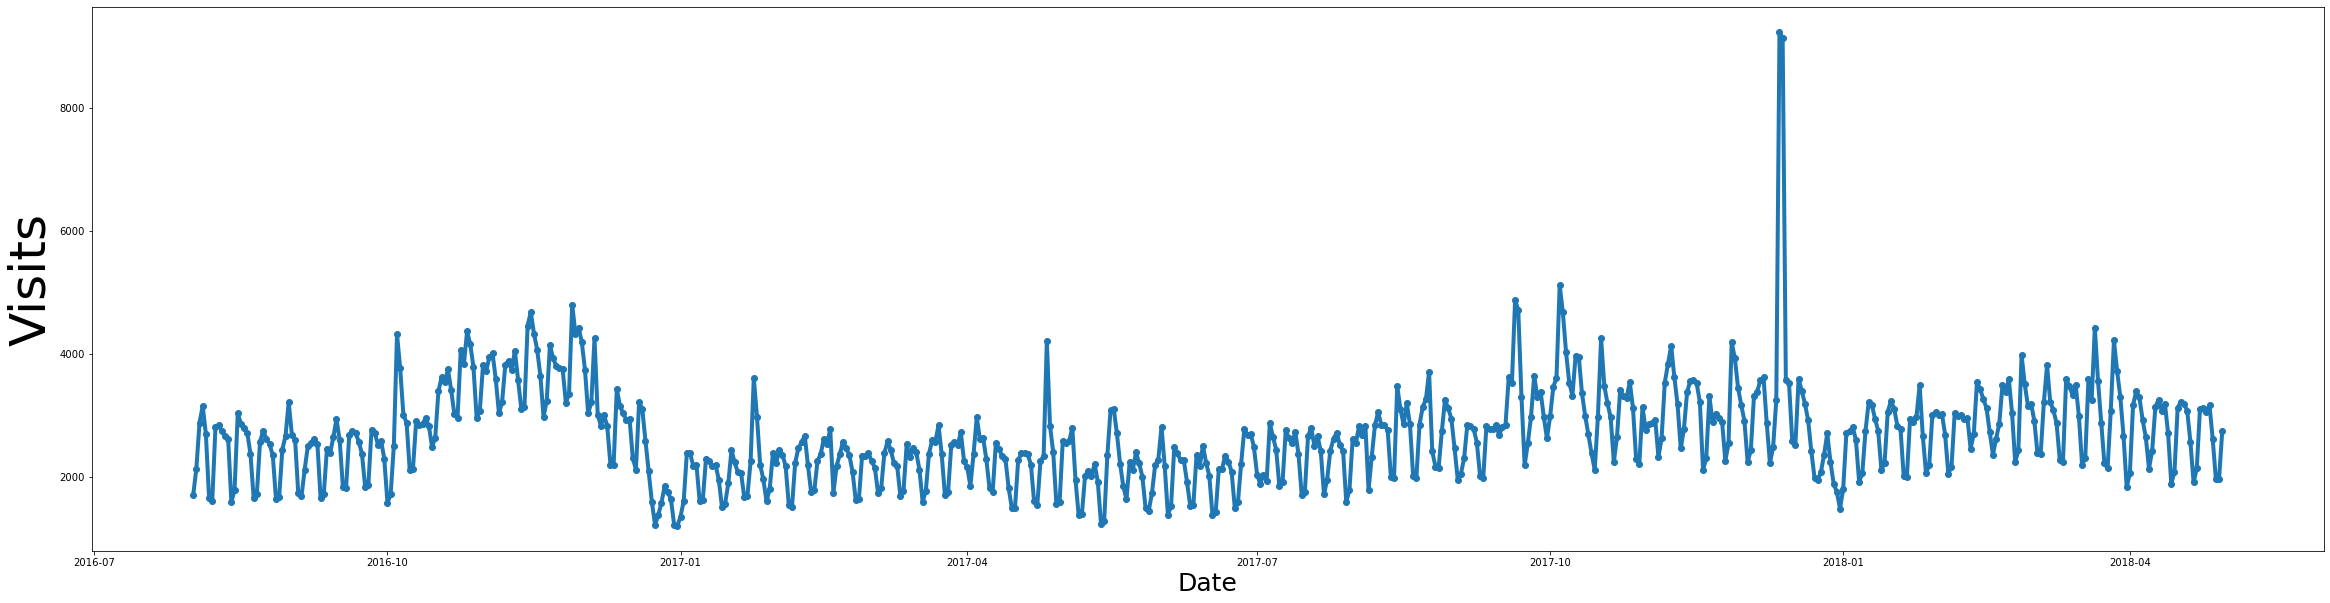

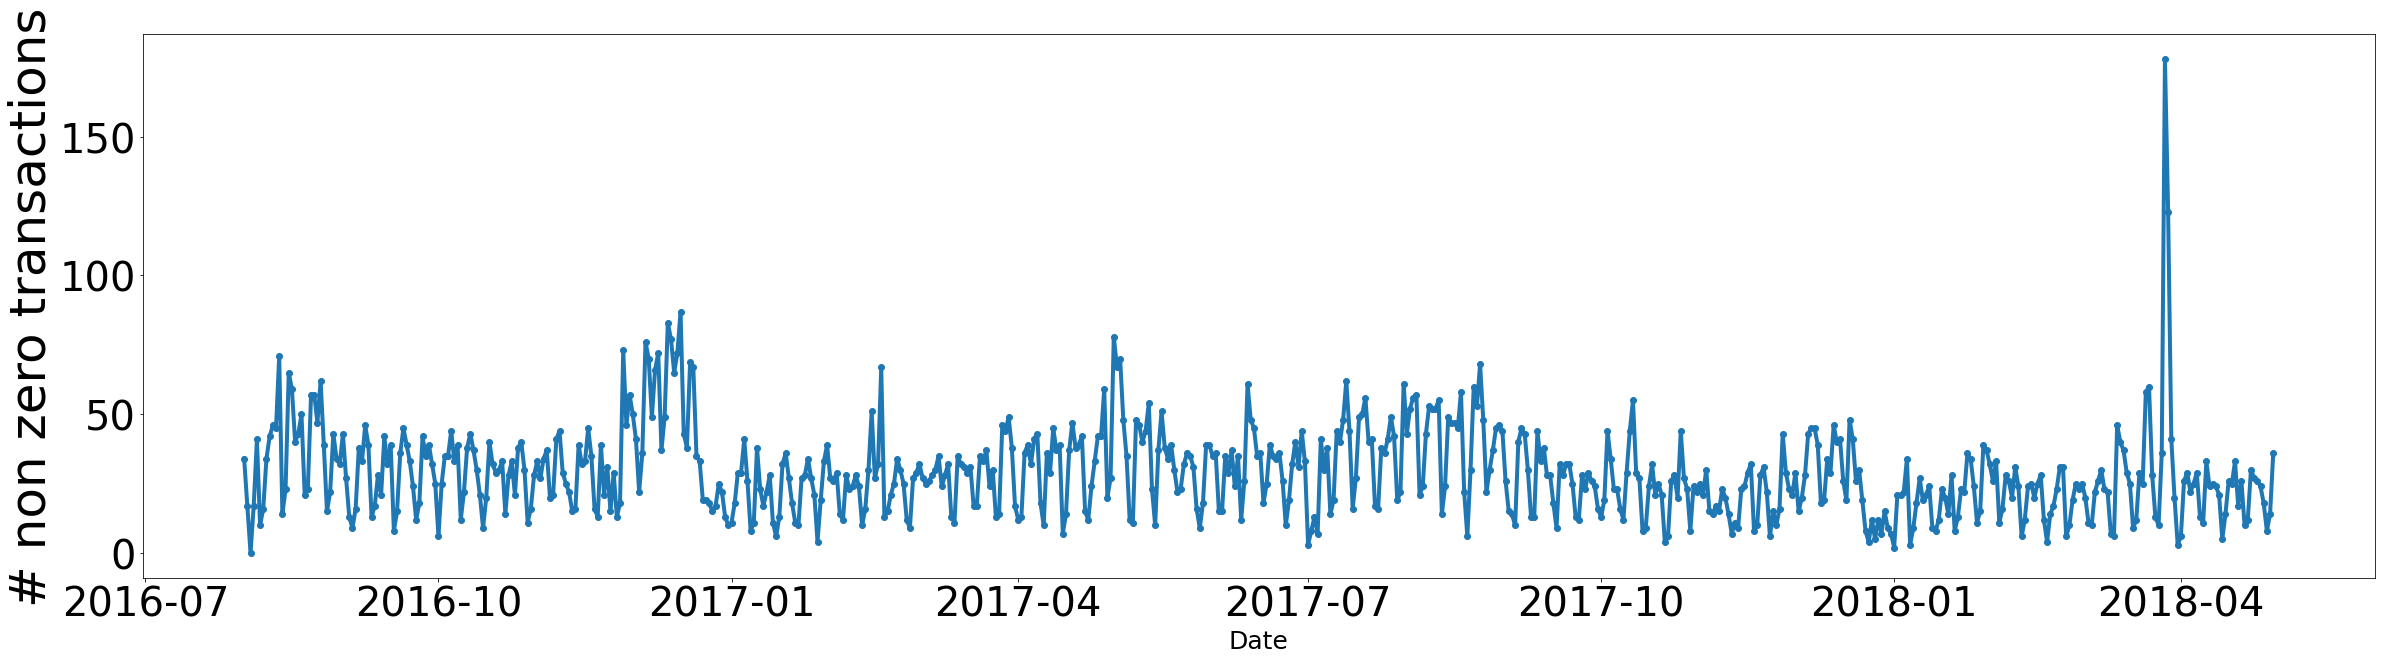

In [ ]:
# no.of vists vs time:
#--------------------

train_df["date"] = pd.to_datetime(train_df["date"], infer_datetime_format=True, format="%Y%m%d") # convert date feature into 
                                                                                                 # exact date format
    

# Compute count of group, excluding missing values(include only non zero values).
counts_group_date = train_df.groupby('date').count()
counts_group_date.reset_index(inplace=True) #it will create indexes from zero to len(dataframe)


# plot for no.of visits in each date :

plt.figure(figsize=(40,10))
plt.plot_date(x = counts_group_date['date'], y = counts_group_date['fullVisitorId'],linestyle='solid',linewidth=4)
plt.xlabel('Date',fontsize=25)
plt.ylabel('Visits',fontsize=50)
plt.rc('xtick', labelsize=40) #increases the value's font on x-axis
plt.rc('ytick', labelsize=40) #increases the value's font on y-axis
plt.autoscale(True)
plt.show()

# plot for transcation revenue in each date :

plt.figure(figsize=(40,10))
plt.plot_date(x = counts_group_date['date'], y = counts_group_date['totals.transactionRevenue'],linestyle='solid',linewidth=4)
plt.xlabel('Date',fontsize=25)
plt.ylabel('# non zero transactions',fontsize=50)
plt.rc('xtick', labelsize=40) #increases the value's font on x-axis
plt.rc('ytick', labelsize=40) #increases the value's font on x-axis
plt.autoscale(True)
plt.show()

In [ ]:
# https://docs.python.org/3/library/datetime.html
#https://stackoverflow.com/questions/42514963/how-to-convert-visit-start-time-to-a-readable-human-date-or-timestamp-in-big-que
from datetime import datetime
def date_feature(df):
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # seting the column as pandas datetime
    df["weekday"] = df['date'].dt.weekday #extra cting week day
    df["day"] = df['date'].dt.day # extracting day
    df["month"] = df['date'].dt.month # extracting month
    df["year"] = df['date'].dt.year # extracting year
    df['visitHour'] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int) #instaed of this we could also use (pd.datetime(df['visitstarttime'], unit = 's').dt.hour
    return df #returning the df after the transformations

In [ ]:
train_df = date_feature(train_df)
test_df = date_feature(test_df)

In [ ]:
train_df

,channelGrouping,customDimensions,date,fullVisitorId,hits,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,...,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,weekday,day,month,year,visitHour
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",2017-10-16,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508198450,1,1508198450,Firefox,Windows,...,NaN,NaN,NaN,NaN,NaN,0,16,10,2017,0
1,Referral,"[{'index': '4', 'value': 'North America'}]",2017-10-16,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",1508176307,6,1508176307,Chrome,Chrome OS,...,NaN,NaN,NaN,NaN,NaN,0,16,10,2017,17
2,Direct,"[{'index': '4', 'value': 'North America'}]",2017-10-16,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",1508201613,1,1508201613,Chrome,Android,...,NaN,NaN,NaN,NaN,NaN,0,16,10,2017,0
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",2017-10-16,9075655783635761930,"[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",1508169851,1,1508169851,Chrome,Windows,...,NaN,NaN,NaN,NaN,NaN,0,16,10,2017,16
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",2017-10-16,6960673291025684308,"[{'hitNumber': '1', 'time': '0', 'hour': '14',...",1508190552,1,1508190552,Chrome,Windows,...,NaN,NaN,NaN,NaN,NaN,0,16,10,2017,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1708332,Social,[],2017-01-04,5123779100307500332,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",1483554750,1,1483554750,Chrome,Windows,...,NaN,NaN,NaN,NaN,NaN,2,4,1,2017,18
1708333,Social,[],2017-01-04,7231728964973959842,"[{'hitNumber': '1', 'time': '0', 'hour': '7', ...",1483543798,1,1483543798,Chrome,Android,...,NaN,NaN,NaN,NaN,NaN,2,4,1,2017,15
1708334,Social,[],2017-01-04,5744576632396406899,"[{'hitNumber': '1', 'time': '0', 'hour': '2', ...",1483526434,1,1483526434,Android Webview,Android,...,NaN,NaN,NaN,NaN,NaN,2,4,1,2017,10
1708335,Social,"[{'index': '4', 'value': 'APAC'}]",2017-01-04,2709355455991750775,"[{'hitNumber': '2', 'time': '0', 'hour': '21',...",1483592857,1,1483592864,Chrome,Windows,...,NaN,NaN,NaN,NaN,NaN,2,4,1,2017,5


In [ ]:
test_df

,channelGrouping,customDimensions,date,fullVisitorId,hits,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,...,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,weekday,day,month,year,visitHour
0,Organic Search,"[{'index': '4', 'value': 'APAC'}]",2018-05-11,7460955084541987166,"[{'hitNumber': '1', 'time': '0', 'hour': '21',...",1526099341,2,1526099341,Chrome,Android,...,(not set),NaN,NaN,NaN,NaN,4,11,5,2018,4
1,Direct,"[{'index': '4', 'value': 'North America'}]",2018-05-11,460252456180441002,"[{'hitNumber': '1', 'time': '0', 'hour': '11',...",1526064483,166,1526064483,Chrome,Macintosh,...,(not set),NaN,NaN,NaN,NaN,4,11,5,2018,18
2,Organic Search,"[{'index': '4', 'value': 'North America'}]",2018-05-11,3461808543879602873,"[{'hitNumber': '1', 'time': '0', 'hour': '12',...",1526067157,2,1526067157,Chrome,Chrome OS,...,(not set),NaN,NaN,NaN,NaN,4,11,5,2018,19
3,Direct,"[{'index': '4', 'value': 'North America'}]",2018-05-11,975129477712150630,"[{'hitNumber': '1', 'time': '0', 'hour': '23',...",1526107551,4,1526107551,Chrome,iOS,...,(not set),NaN,NaN,NaN,NaN,4,11,5,2018,6
4,Organic Search,"[{'index': '4', 'value': 'North America'}]",2018-05-11,8381672768065729990,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",1526060254,1,1526060254,Internet Explorer,Windows,...,(not set),NaN,NaN,NaN,NaN,4,11,5,2018,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401584,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",2018-09-07,6701149525099562370,"[{'hitNumber': '1', 'time': '0', 'hour': '13',...",1536353803,1,1536353803,Chrome,Android,...,(not set),NaN,NaN,NaN,NaN,4,7,9,2018,20
401585,Organic Search,"[{'index': '4', 'value': 'North America'}]",2018-09-07,6154541330147351453,"[{'hitNumber': '1', 'time': '0', 'hour': '23',...",1536388075,1,1536388075,Chrome,Windows,...,(not set),NaN,NaN,NaN,NaN,4,7,9,2018,6
401586,Organic Search,[],2018-09-07,6013469762773705448,"[{'hitNumber': '1', 'time': '0', 'hour': '13',...",1536351791,3,1536351791,Firefox,Windows,...,(not set),NaN,NaN,NaN,NaN,4,7,9,2018,20
401587,Organic Search,"[{'index': '4', 'value': 'North America'}]",2018-09-07,4565378823441900999,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",1536340217,1,1536340217,Chrome,Chrome OS,...,(not set),NaN,NaN,NaN,NaN,4,7,9,2018,17


# Creating is_weekend feature

In [ ]:
weekday_vals = train_df['weekday'].values
weekend = []
for i in weekday_vals:
    if (i == 0) or (i == 6):
        weekend.append(1)
    else:
        weekend.append(0)
train_df['is_weekend'] = weekend

In [ ]:
weekday_vals_t = test_df['weekday'].values
weekend_t = []
for i in weekday_vals_t:
    if (i == 0) or (i == 6):
        weekend_t.append(1)
    else:
        weekend_t.append(0)
test_df['is_weekend'] = weekend_t

# Weekdays Analysis

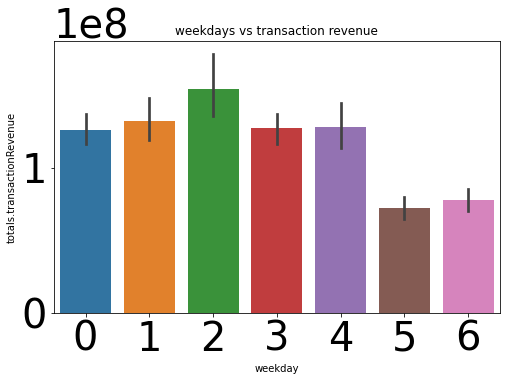

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(train_df['weekday'], train_df['totals.transactionRevenue'],data = train_df )
plt.title('weekdays vs transaction revenue')
plt.show()

# Days of a month Analysis

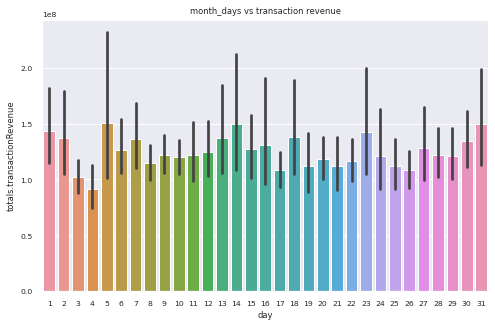

In [ ]:
#lets look at the days of each month:-
plt.figure(figsize=(8,5))
sns.barplot(train_df['day'], train_df['totals.transactionRevenue'], data = train_df)
plt.title('month_days vs transaction revenue')
plt.show()

# Month Analysis

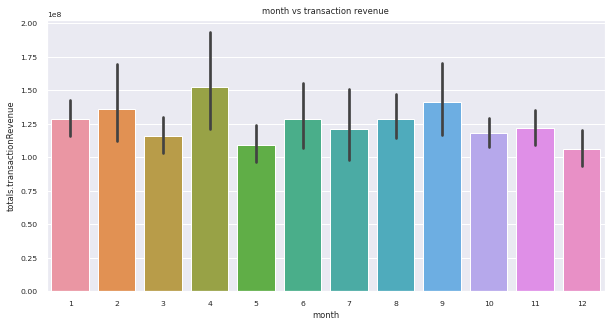

In [ ]:
#lets look at the month:-
plt.figure(figsize=(10,5))
sns.barplot(train_df['month'], train_df['totals.transactionRevenue'], data = train_df)
plt.title('month vs transaction revenue')
plt.show()

# Year Analysis

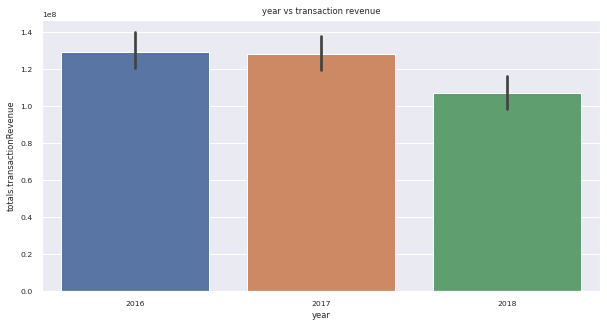

In [ ]:
#lets look at year
#lets look at the days of each month:-
plt.figure(figsize=(10,5))
sns.barplot(train_df['year'], train_df['totals.transactionRevenue'], data = train_df)
plt.title('year vs transaction revenue')
plt.show()

# is_weekend Analysis

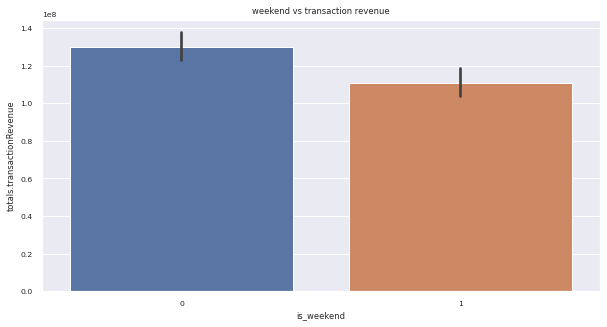

In [ ]:
#lets look at year
#lets look at the days of each month:-
plt.figure(figsize=(10,5))
sns.barplot(train_df['is_weekend'], train_df['totals.transactionRevenue'], data = train_df)
plt.title('weekend vs transaction revenue')
plt.show()

# visitHour Analysis

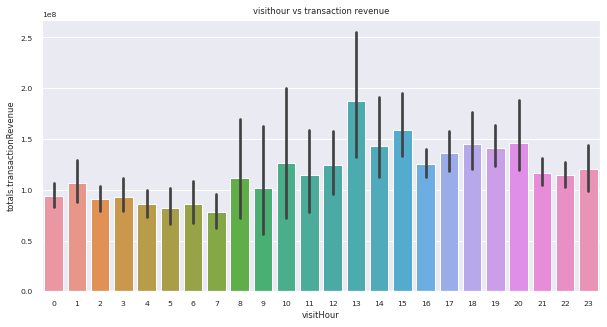

In [ ]:
#lets look at visit hour: which is the visit start time in hour
plt.figure(figsize=(10,5))
sns.barplot(train_df['visitHour'], train_df['totals.transactionRevenue'], data = train_df)
plt.title('visithour vs transaction revenue')
plt.show()

In [ ]:
temp = train_df.groupby("date")["totals.transactionRevenue"].sum().reset_index() 

In [ ]:
temp.sort_values(by=['totals.transactionRevenue'], ascending=False)

,date,totals.transactionRevenue
247,2017-04-05,2.715061e+10
197,2017-02-14,2.302837e+10
46,2016-09-16,2.026647e+10
366,2017-08-02,1.733500e+10
24,2016-08-25,1.718621e+10
...,...,...
334,2017-07-01,8.454000e+07
180,2017-01-28,7.054000e+07
518,2018-01-01,6.728000e+07
607,2018-03-31,5.591000e+07


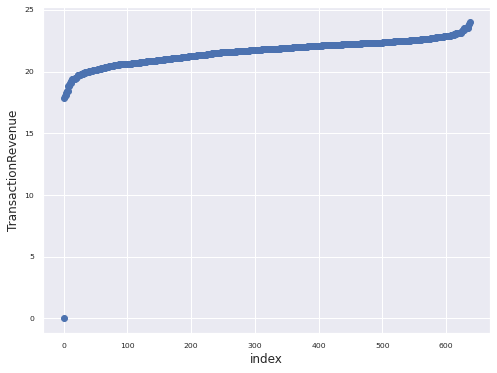

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(range(temp.shape[0]), np.sort(np.log1p(temp["totals.transactionRevenue"].values))) # log(transaction_revenue)
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

<br>

 - totals.transactions:
 <br>
 Total number of ecommerce transactions within the session., so we will fill nulls with zeros.

In [ ]:
train_df['totals.transactions'].fillna(0, inplace=True)
test_df['totals.transactions'].fillna(0, inplace=True)

<br>

 - totals.totalTransactionRevenue :
 <br>
 we will impute the missing values with zero

 - totals.transactionRevenue:
 <br>
 we will impute the missing values with zero

### Note:
 - Actually both totaltranasactionRevenue and tranasactionRevenue referred same meaning., but kaggle is using 'tranasactionRevenue' as target feature., google official anlytics document says that tranasactionRevenue' was deprecated and use 'totaltranasactionRevenue' as target feature.
 - so for time being we will follow kaggle given target variable.
 <br>
 
https://www.kaggle.com/c/ga-customer-revenue-prediction/discussion/71779
<br>
https://support.google.com/analytics/answer/3437719?hl=en

In [ ]:
train_df['totals.transactionRevenue'].fillna(0, inplace=True)
test_df['totals.transactionRevenue'].fillna(0, inplace=True)

<br>

 - Hits:

In [ ]:
# if analyse the 'hits' feature it seems to be have very complex daata., this complex data won't add any value to our target
# feature so we will drop this feature also.
train_df['hits'][0]

"[{'hitNumber': '1', 'time': '0', 'hour': '17', 'minute': '0', 'isInteraction': True, 'isEntrance': True, 'isExit': True, 'referer': 'https://www.google.co.uk/search?q=water+bottle&ie=utf-8&num=100&oe=utf-8&hl=en&gl=GB&uule=w+CAIQIFISCamRx0IRO1oCEXoliDJDoPjE&glp=1&gws_rd=cr&fg=1', 'page': {'pagePath': '/google+redesign/bags/water+bottles+and+tumblers', 'hostname': 'shop.googlemerchandisestore.com', 'pageTitle': 'Water Bottles & Tumblers | Drinkware | Google Merchandise Store', 'pagePathLevel1': '/google+redesign/', 'pagePathLevel2': '/bags/', 'pagePathLevel3': '/water+bottles+and+tumblers', 'pagePathLevel4': ''}, 'transaction': {'currencyCode': 'USD'}, 'item': {'currencyCode': 'USD'}, 'appInfo': {'screenName': 'shop.googlemerchandisestore.com/google+redesign/bags/water+bottles+and+tumblers', 'landingScreenName': 'shop.googlemerchandisestore.com/google+redesign/bags/water+bottles+and+tumblers', 'exitScreenName': 'shop.googlemerchandisestore.com/google+redesign/bags/water+bottles+and+tum

<br>

 - customDimensions:
 this feature also not seems to be very important. so we will drop this feature also

In [ ]:
train_df['customDimensions'][0]

"[{'index': '4', 'value': 'EMEA'}]"

____________________

In [ ]:
# so after preprocessing the list of Columns to be dropped in given data are:

cols_to_drop = ['totals.totalTransactionRevenue']+['customDimensions'] + ['hits'] + \
            ["trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", "trafficSource.adwordsClickInfo.slot",
            "trafficSource.adwordsClickInfo.page"]


for feature in cols_to_drop:
    if feature in test_df.columns:
        del test_df[feature]
        
    if feature in train_df.columns:
        del train_df[feature]
    


In [ ]:
# final data after removing some columns:
print("shape of train data: {0} and test data: {1}".format(train_df.shape,test_df.shape))

shape of train data: (1708337, 35) and test data: (401589, 35)


In [ ]:
# our final features are:
train_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'visitId', 'visitNumber',
       'visitStartTime', 'device.browser', 'device.operatingSystem',
       'device.isMobile', 'device.deviceCategory', 'geoNetwork.continent',
       'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region',
       'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain',
       'totals.hits', 'totals.pageviews', 'totals.sessionQualityDim',
       'totals.timeOnSite', 'totals.transactions', 'totals.transactionRevenue',
       'trafficSource.campaign', 'trafficSource.source',
       'trafficSource.medium', 'trafficSource.keyword',
       'trafficSource.referralPath', 'trafficSource.adContent', 'weekday',
       'day', 'month', 'year', 'visitHour', 'is_weekend'],
      dtype='object')

In [ ]:
train_df.to_csv('preprocessed_train_df_time.csv')
test_df.to_csv('preprocessed_test_df_time.csv')

In [ ]:
# saving the preprocessed data into files:

# storing data frames as csv files:
#train_df.to_csv('case study data/preprocessed_train_df.csv')
#test_df.to_csv('case study data/preprocessed_test_df.csv')

# reading from files
train_df = pd.read_csv('preprocessed_train_df_time.csv',dtype={'fullVisitorId': 'str'},index_col=0)
test_df = pd.read_csv('preprocessed_test_df_time.csv',dtype={'fullVisitorId': 'str'},index_col=0)


In [ ]:
train_df = train_df.reset_index()
test_df  = test_df.reset_index()

_______________________________________

## 4.Exploratory data analysis :

______________________________________________________

#### 4.1 target feature analysis:

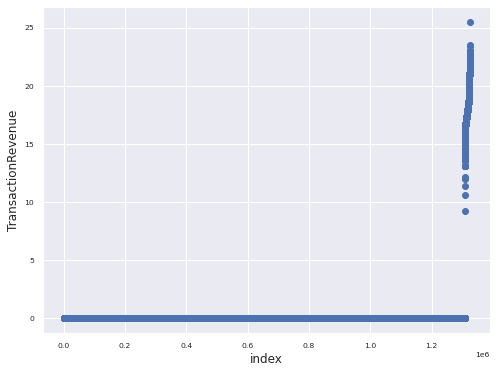

In [ ]:
# credits:https://github.com/flaviassantos/google_revenue_predict/blob/master/notebooks/2.0-Exploratory-Data-Analysis.ipynb

train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float') # converting to 'float' datatype
temp = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index() # for each user we are taking sum of  
                                                                                       # all his transactions

plt.figure(figsize=(8,6))
plt.scatter(range(temp.shape[0]), np.sort(np.log1p(temp["totals.transactionRevenue"].values))) # log(transaction_revenue)
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

 - observatoin: as we already discussed about 80/20 rule., by looking at this graph it was proved ., most of the transactions had generated zero revenue but only few transactions had no-zero revenue.

#### 4.2  non-zero transactions analysis:

In [ ]:
non_zero_Revenue_records = 0
unique_users_with_non_zero_revenue = set()
 
for i,j in zip(train_df['totals.transactionRevenue'],train_df['fullVisitorId']):
    if i>0:
        non_zero_Revenue_records += 1
        unique_users_with_non_zero_revenue.add(j)

print("total no.of transactions with non-zero revenue out of: {0} are: {1} and \
which is about :{2} %".format(train_df.shape[0],non_zero_Revenue_records,(non_zero_Revenue_records*100)/(train_df.shape[0])))

print("\n")

print("out of {0} customers only {1} customers are generating revenue and which is about: {2}%" \
      .format(train_df['fullVisitorId'].nunique(),len(unique_users_with_non_zero_revenue),(len(unique_users_with_non_zero_revenue))*100/train_df['fullVisitorId'].nunique()))

total no.of transactions with non-zero revenue out of: 1708337 are: 18514 and which is about :1.0837440153786988 %


out of 1323730 customers only 16141 customers are generating revenue and which is about: 1.219357421830736%


______________________________________

<br>

#### 4.3 train and test users:

In [ ]:
print("common users between train and test are: ",len(set(train_df.fullVisitorId).intersection(set(test_df.fullVisitorId))))

common users between train and test are:  2759


<br>

#### 4.4 trend analysis :

 - no.of visits over time: In our data each reocrd corresponds to one visit.

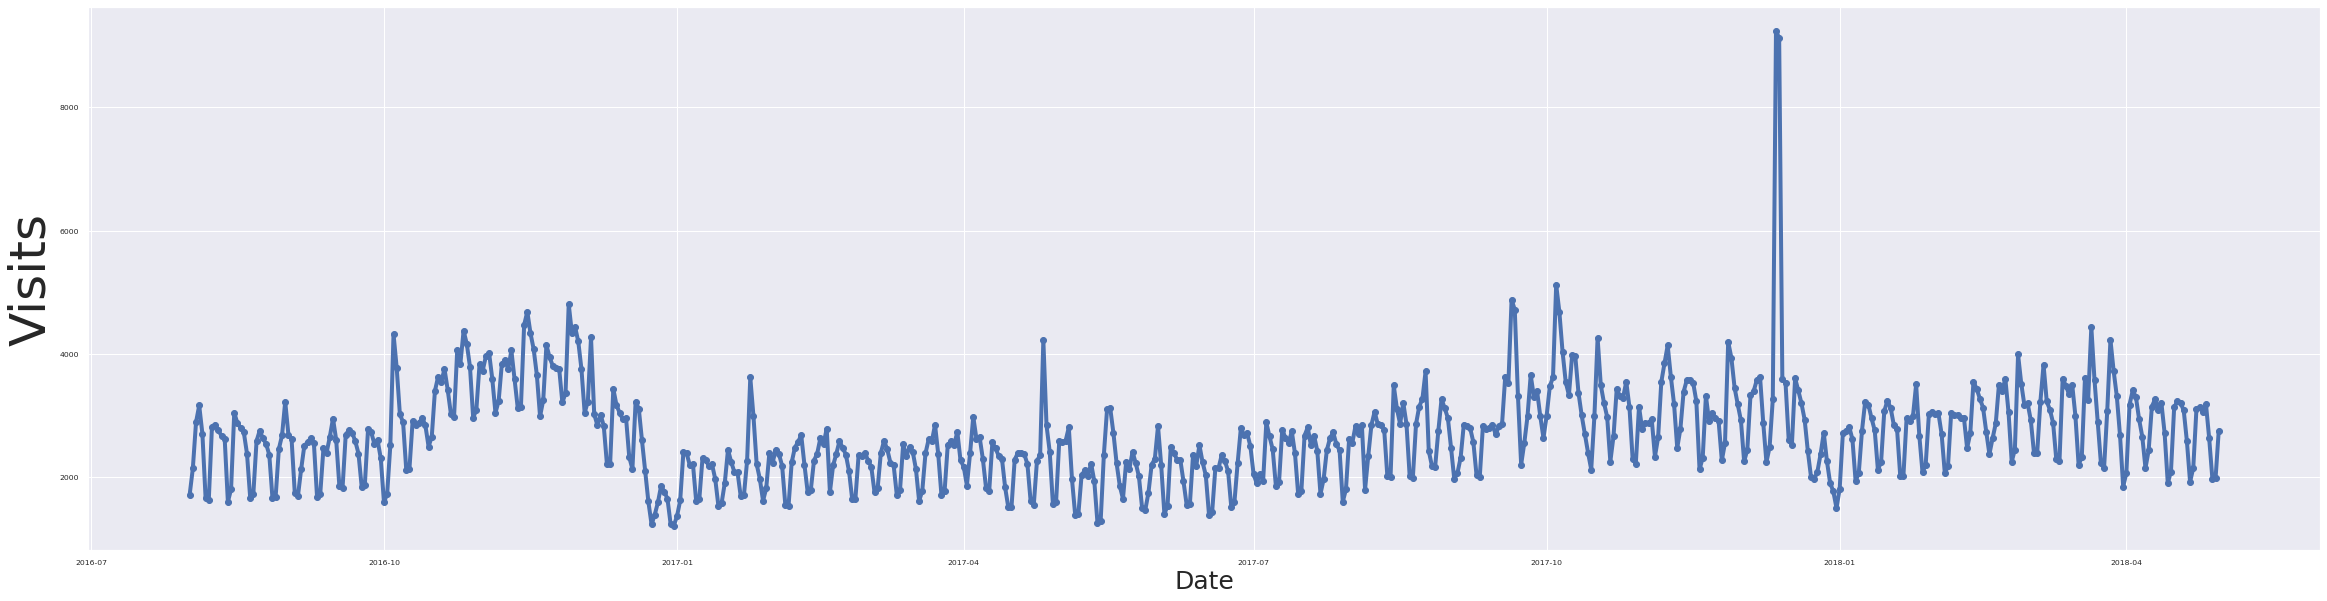

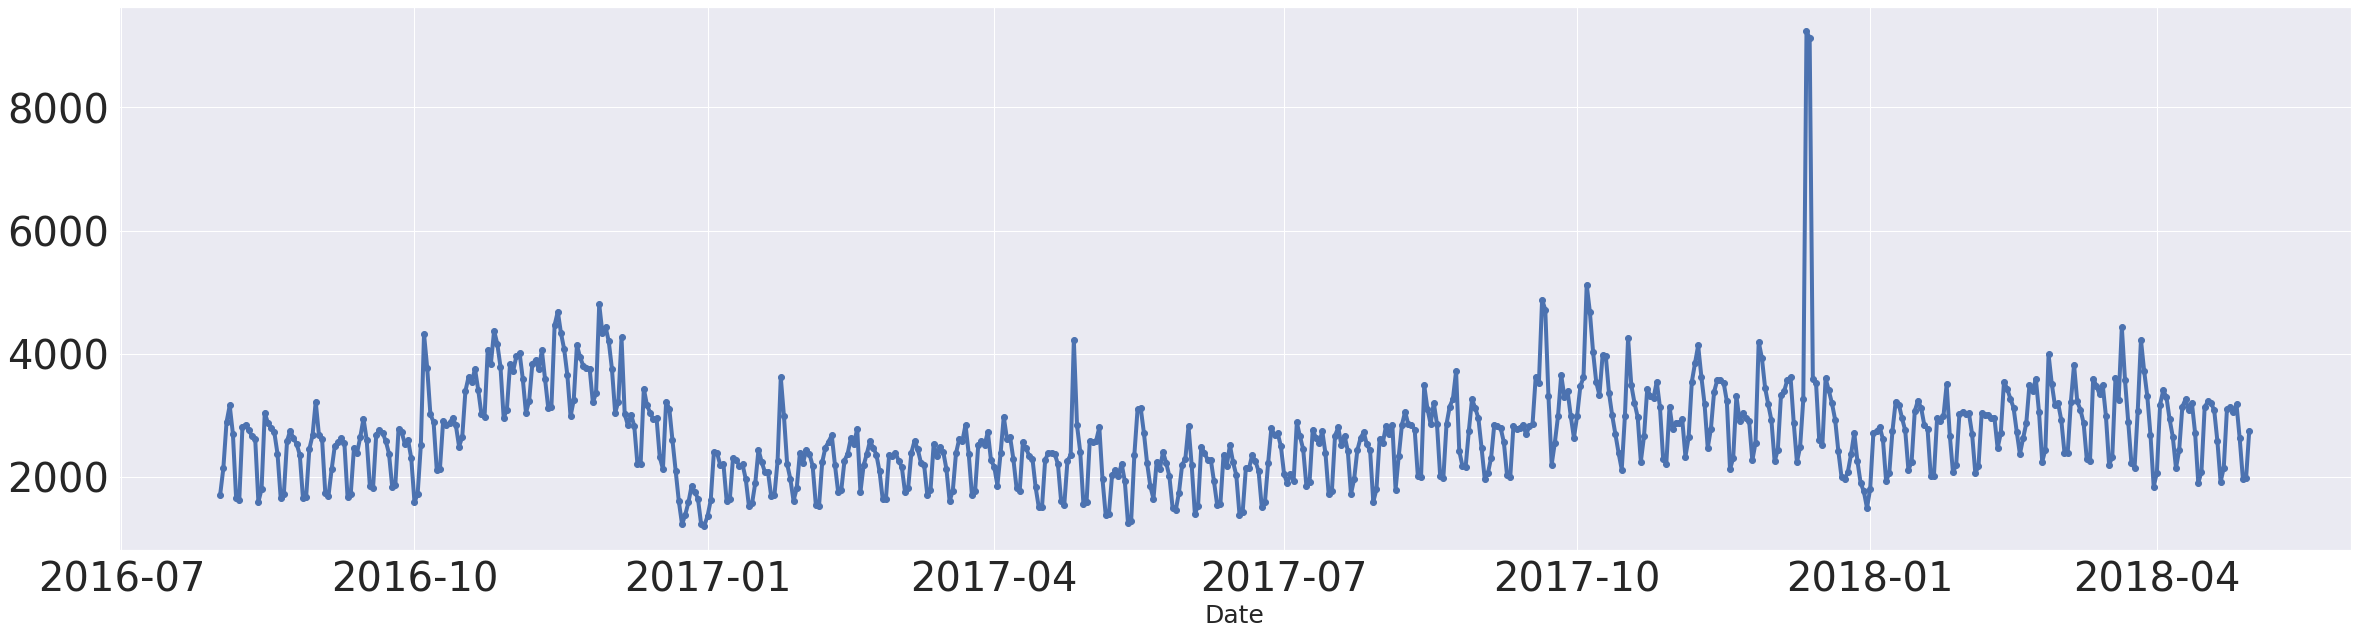

In [ ]:
# no.of vists vs time:
#--------------------

train_df["date"] = pd.to_datetime(train_df["date"], infer_datetime_format=True, format="%Y%m%d") # convert date feature into 
                                                                                                 # exact date format
    

# Compute count of group, excluding missing values(include only non zero values).
counts_group_date = train_df.groupby('date').count()
counts_group_date.reset_index(inplace=True) #it will create indexes from zero to len(dataframe)


# plot for no.of visits in each date :

plt.figure(figsize=(40,10))
plt.plot_date(x = counts_group_date['date'], y = counts_group_date['fullVisitorId'],linestyle='solid',linewidth=4)
plt.xlabel('Date',fontsize=25)
plt.ylabel('Visits',fontsize=50)
plt.rc('xtick', labelsize=40) #increases the value's font on x-axis
plt.rc('ytick', labelsize=40) #increases the value's font on y-axis
plt.autoscale(True)
plt.show()

# plot for transcation revenue in each date :

plt.figure(figsize=(40,10))
plt.plot_date(x = counts_group_date['date'], y = counts_group_date['totals.transactionRevenue'],linestyle='solid',linewidth=4)
plt.xlabel('Date',fontsize=25)
plt.rc('xtick', labelsize=40) #increases the value's font on x-axis
plt.rc('ytick', labelsize=40) #increases the value's font on x-axis
plt.autoscale(True)
plt.show()

<br>
<br>
 
 - observation:
  - in the month of december-2017 the the no.of vists and revune are raised drastically.
  - so this one of the useful inights to the promotional team., so that they can invest more money in promotions in the month of december

____________________________

In [ ]:
# difference between size and count:- size includes NaN values, count does not:
def plt_categories(df, col):
    df1 = df.groupby(col)['fullVisitorId'].count().reset_index()
    df2 = df.groupby(col)["totals.transactionRevenue"].sum().reset_index()
    df1 = df1.sort_values(by = 'fullVisitorId', ascending = False)
    df2 = df2.sort_values(by = 'totals.transactionRevenue', ascending = False)
    df1 = df1[:5]
    df2 = df2[:5]
    plt.figure(figsize=(10,5))
    sns.barplot(df1[col],df1['fullVisitorId'],linewidth = 0.7)
    plt.title('visitors vs  '+ str(col))
    plt.xticks(rotation=20,fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
    plt.figure(figsize=(10,5))
    sns.barplot(df2[col],df2['totals.transactionRevenue'])
    plt.title('transactionRevenue vs  '+ str(col))
    plt.xticks(rotation=30,fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()

#### 4.5 Channel grouping analysis:

 - no.of visits per each channel
 - total revenue generated per each channel
 

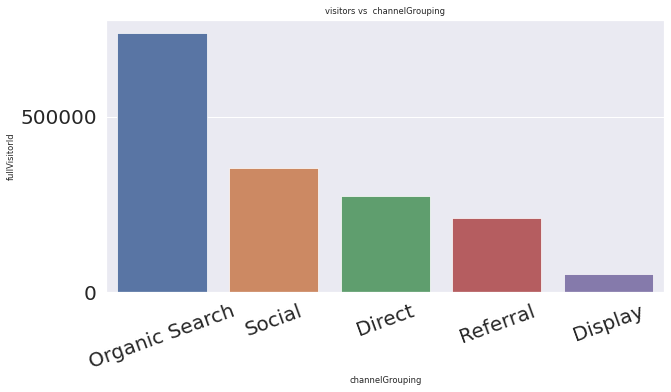

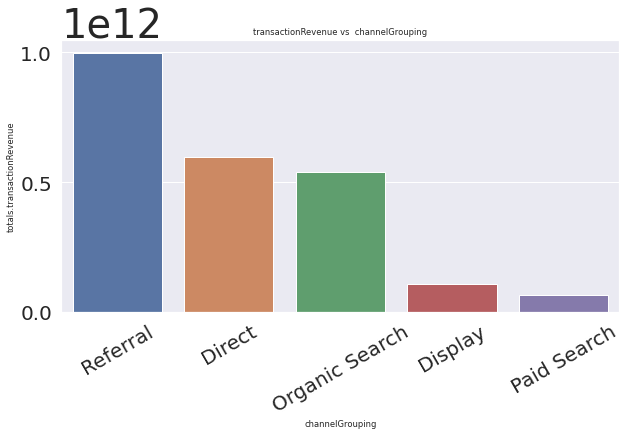

In [ ]:
plt_categories(train_df,'channelGrouping')

<br>
<br>
<br>

 - observations:
  - The most revenue is coming from 'organic search', 'Direct','Referral'.., but no.of visits in 'Direct', 'referral' are very less.
  - so here conclusion is the analyitcs team can invest less money in 'Direct','referral' channels (since less users are visting from this channel) and can generate most revenue.

<br>
<br>

___________________________

#### 4.6 web-browser analysis:

 - no.of visits per each browser
 - total revenue generated per each browser
 - It's very difficult to analyse all the browsers that we had in train data( since it had some of the browsers that we had never known)., so we will analyze only top 20 browsers.(here top means depends on their occurence in train data)

In [ ]:
train_df['device.browser'].value_counts()

Chrome                        1173056
Safari                         312165
Firefox                         63845
Internet Explorer               35474
Android Webview                 34266
                               ...   
fspmihbxzowgnuctrqykjlvade          1
cajrnbtvqwfkolzyxushpdgime          1
Dillo                               1
lhkbrtuwomdeafnqygvxcspizj          1
ADM                                 1
Name: device.browser, Length: 129, dtype: int64

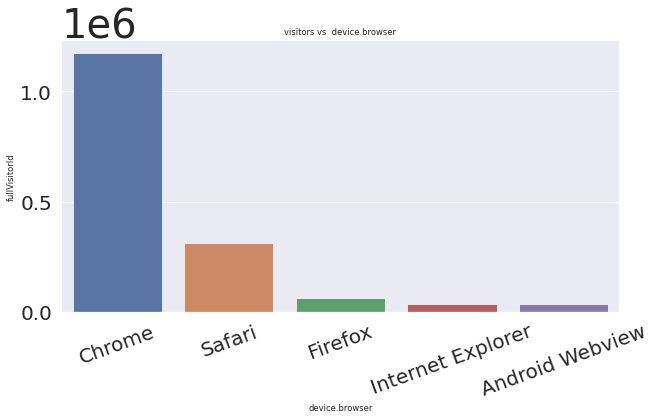

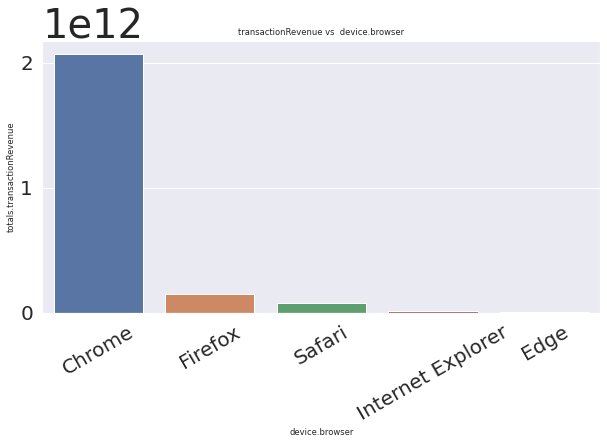

In [ ]:
plt_categories(train_df,'device.browser')

<br>
<br>
<br>

 - observations:
  - The no.of visits in chorme browser are very huge compare with all browsers.
  - The most revenue is coming from 'chrome', 'Firefox','safari','Internet explorer','edge','opera','samsung intrnet','android web view','safari','amazon silk','YaBrowser'.., 
  - so here conclusion is the analyitcs team can invest less money on the users visting store through browsers(ex:safari,firefox,opera,edge) except chrome  and can generate most revenue.

#### 4.7 operatingSystem analysis:

 - no.of visits per each operating system
 - total revenue generated per each operating system
 

In [ ]:
train_df['device.operatingSystem'].value_counts()

Windows             619720
Macintosh           438514
Android             299386
iOS                 219334
Linux                63971
Chrome OS            51318
(not set)            11815
Windows Phone         1675
Samsung                911
Tizen                  709
BlackBerry             350
OS/2                   199
Xbox                   133
Nintendo Wii           100
Firefox OS              97
Nintendo WiiU           51
FreeBSD                 18
Playstation Vita        15
Nintendo 3DS             9
Nokia                    3
SunOS                    3
OpenBSD                  3
SymbianOS                2
NTT DoCoMo               1
Name: device.operatingSystem, dtype: int64

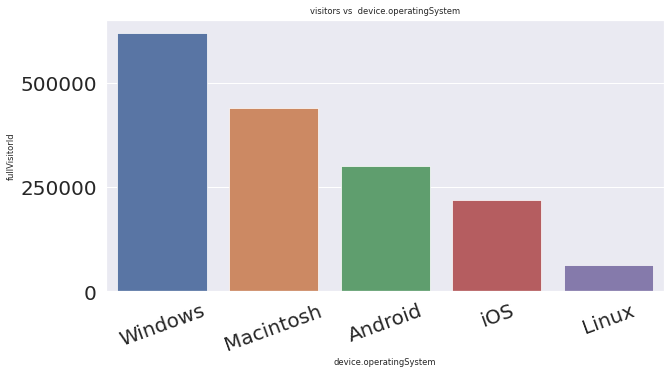

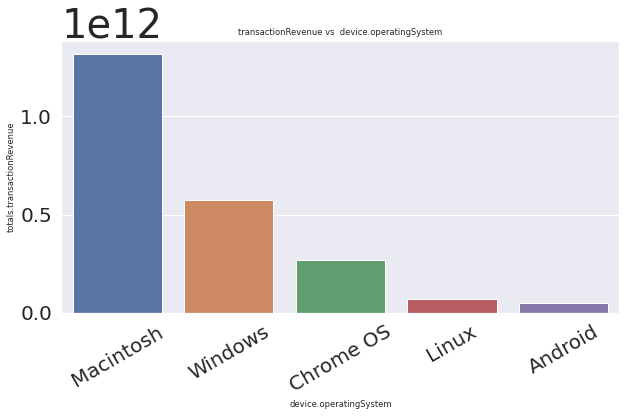

In [ ]:
plt_categories(train_df,'device.operatingSystem')

<br>
<br>

 - Observations:
  - Most of the users are vsiting through Windows,macintosh and the most revenue is generating from windows and macintosh
  - If we observe carefully very less people (less than 100K) are visting through linux and chrome os., so business team can invest very less on money for promotions on this two os platforms and can generate most revenue.
  - very importantly through windows phone less than 2000 people are visitng merchandise site but they are also generatng good amout of revenue. so analytics team can invest less money on the windows phone os and can generate good revenue.

__________________________________

#### 4.8 deviceCategory analysis:

 - no.of visits per each device
 - total revenue generated per each device
 

In [ ]:
train_df['device.deviceCategory'].value_counts()

desktop    1171579
mobile      471336
tablet       65422
Name: device.deviceCategory, dtype: int64

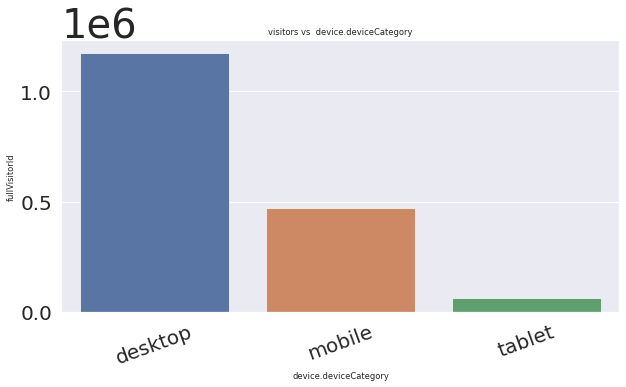

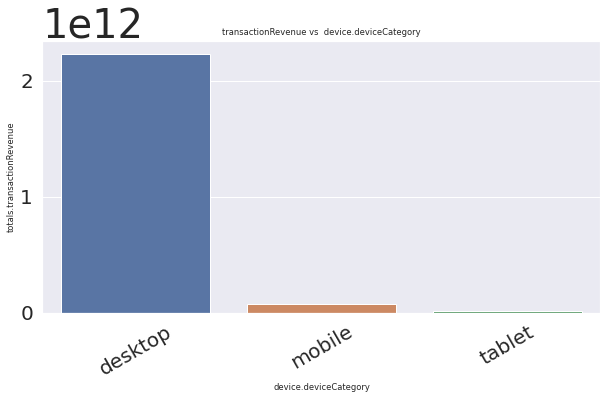

In [ ]:
plt_categories(train_df,'device.deviceCategory')

<br>
<br>

 - observation:
  - Most of the users are vsiting through desktop
  - here the very important observation is through tablet device less than 68K people(this is significantly less compare with other devices) are visiting but they are generating significantly higher revenue.
  - so analytics team can invest less amount of money for promotions on the users visting store through 'tablet device' and can generate signifincatly higher revenue.

<br>

________________

<br>

#### 4.9 Mobile vs non-mobile analysis:

 - no.of visits with mobile and other than mobile
 - total revenue generated with mobile and other than mobile
 

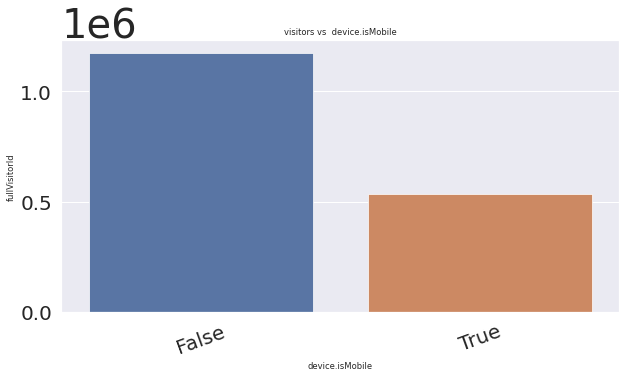

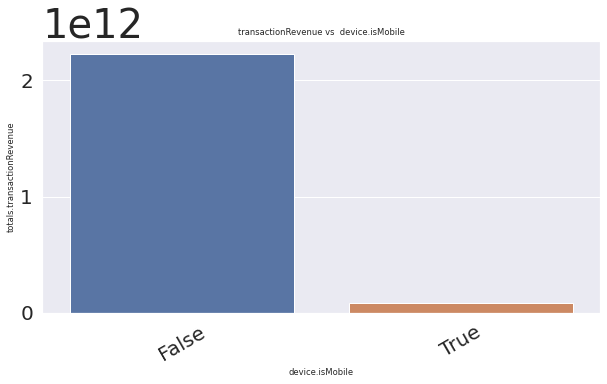

In [ ]:
plt_categories(train_df, 'device.isMobile')

<br>
<br>

 - observation:
  - so many users are coming through non-mobile devices and more revnue is generating from non-mobile devices
  - no.of vistors are relatively very less in mobile users but they are also generating significantly good revenue as compared to non-mobile users.

<br>

#### 4.10 continent analysis:

 - no.of visits per each continent
 - total revenue generated wper each continent
 

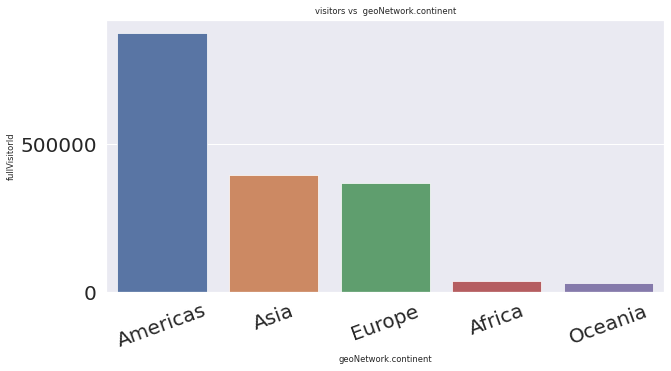

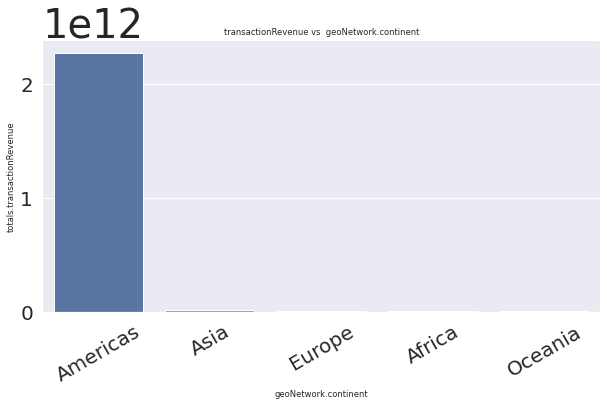

In [ ]:
plt_categories(train_df, 'geoNetwork.continent')

<br>
<br>

 - observation:
  - no.of visits from america are significantly more compare with other continents
  - even no.of visits are less from 'oceania','africa'., but this continents are also generating googd amount of revenue. so its's better to invest in this two continents sources

<br>

#### 4.11 trafficSource analysis:

 - no.of visits per each traffic source
 - total revenue generated per each traffic source
 - It's very difficult to analyse all the trafficSource that we had in train data(we had about 345 differet trafficSources)., so we will analyze only top 20 browsers.(here top means depends on their occurence in train data)
 

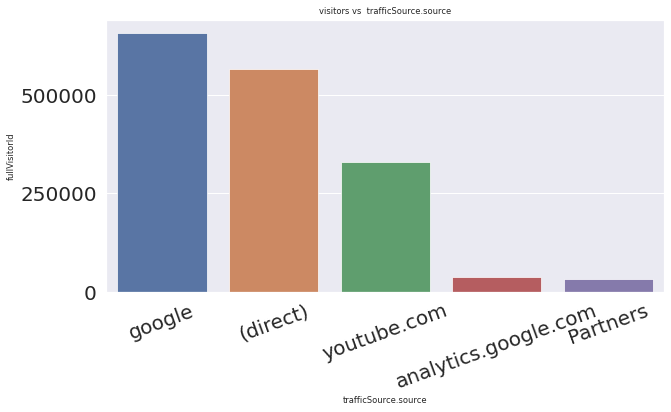

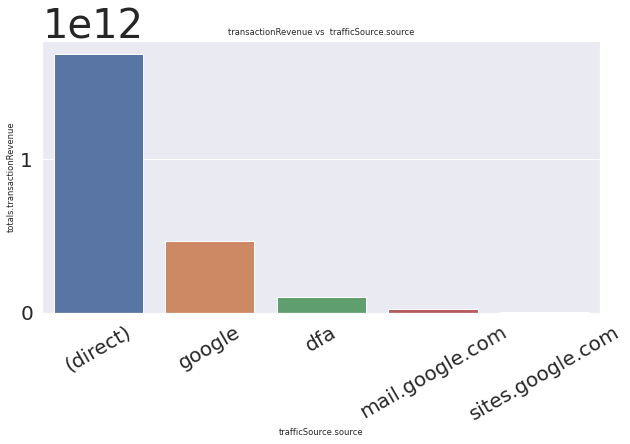

In [ ]:
plt_categories(train_df, 'trafficSource.source')

<br>
<br>

 - observation:
  - most users are visiting through google, direct,youtube
  - even less no.of are users are visiting thorugh 'reddit','analytics.google.com','yahoo','facebook' but significantly they are also generating good amount of revenue. so it's better to invest on this sources to gain maximum revenue.

In [ ]:
train_df.columns

Index(['index', 'channelGrouping', 'date', 'fullVisitorId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.operatingSystem', 'device.isMobile', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.networkDomain', 'totals.hits', 'totals.pageviews',
       'totals.sessionQualityDim', 'totals.timeOnSite', 'totals.transactions',
       'totals.transactionRevenue', 'trafficSource.campaign',
       'trafficSource.source', 'trafficSource.medium', 'trafficSource.keyword',
       'trafficSource.referralPath', 'trafficSource.adContent', 'weekday',
       'day', 'month', 'year', 'visitHour', 'is_weekend'],
      dtype='object')

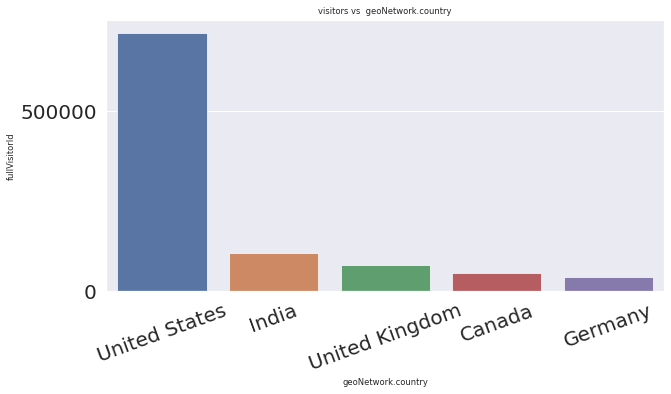

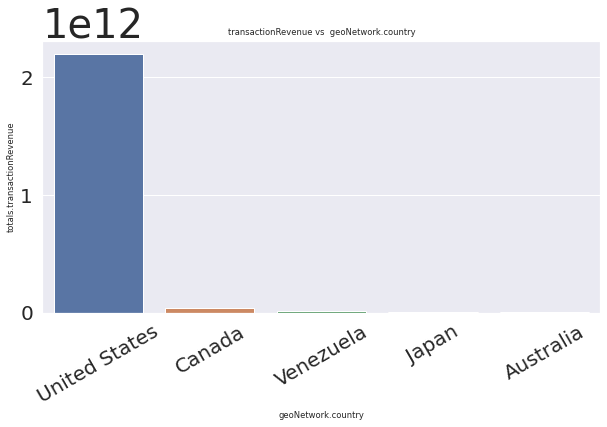

In [ ]:
plt_categories(train_df, 'geoNetwork.country')

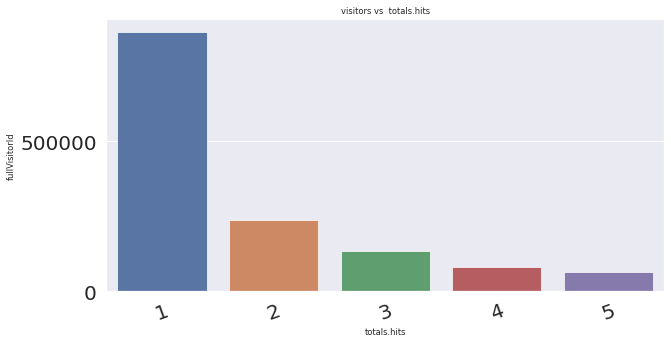

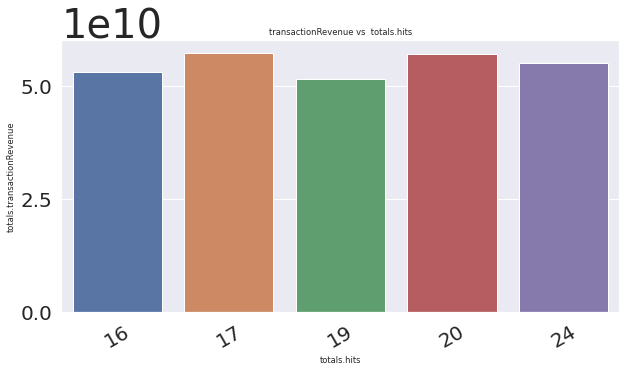

In [ ]:
plt_categories(train_df, 'totals.hits')

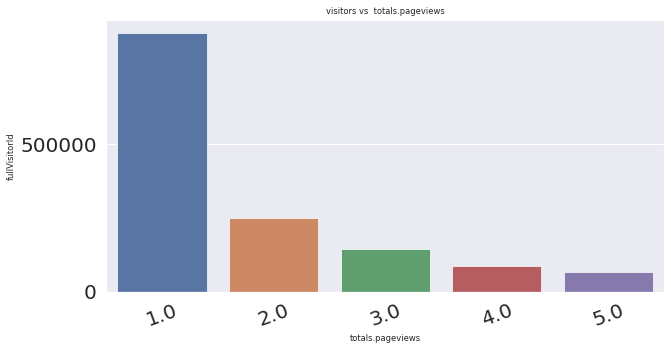

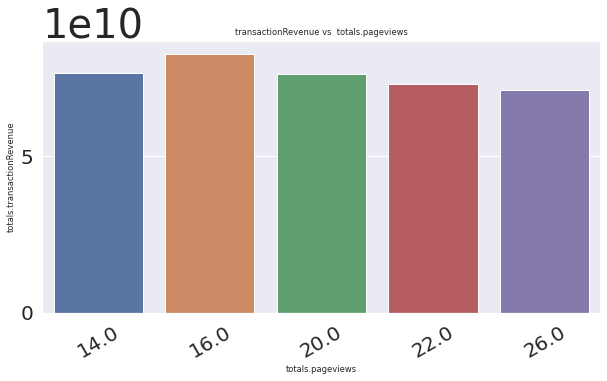

In [ ]:
plt_categories(train_df, 'totals.pageviews')

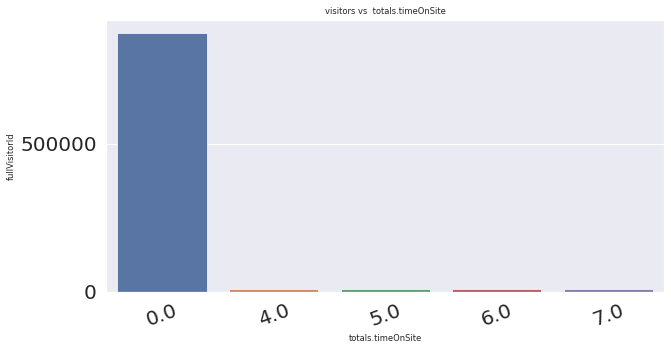

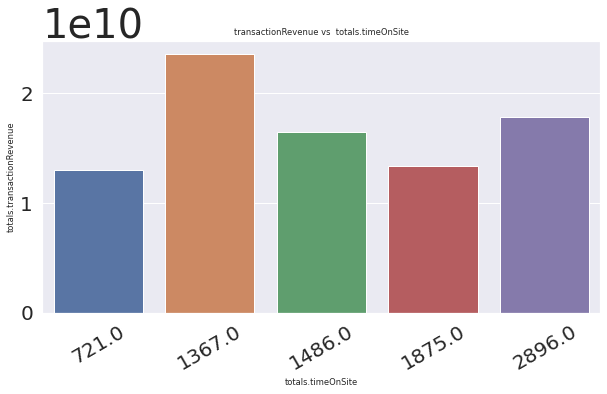

In [ ]:
plt_categories(train_df, 'totals.timeOnSite')

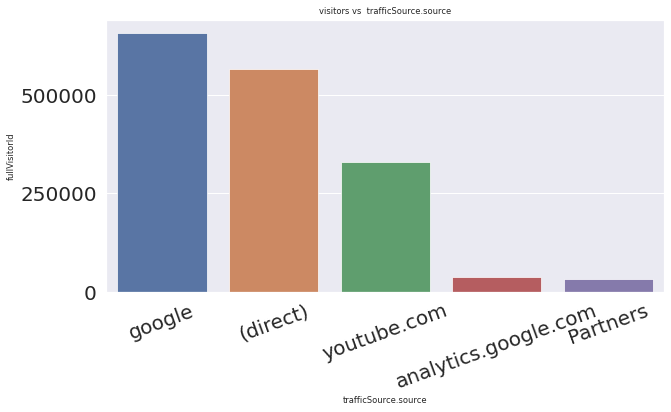

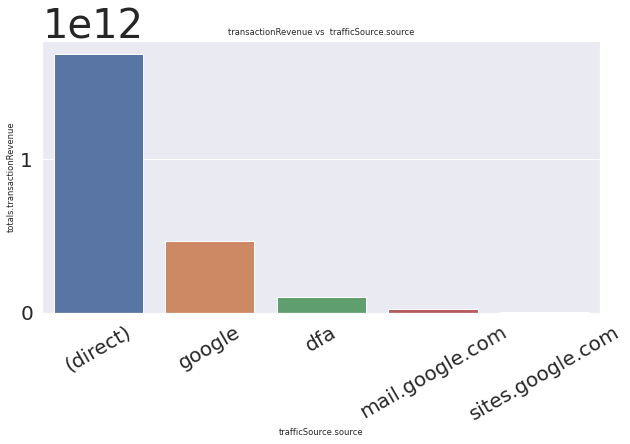

In [ ]:
plt_categories(train_df, 'trafficSource.source')

<br>

_______________________________

## 5.Feature engineering :

In [ ]:
#so are we are imputing zero for missing values in target feature:

train_df['totals.transactionRevenue'].fillna(0,inplace=True)

In [ ]:
# the features and their data types:
train_df.dtypes

index                                  int64
channelGrouping                       object
date                          datetime64[ns]
fullVisitorId                         object
visitId                                int64
visitNumber                            int64
visitStartTime                         int64
device.browser                        object
device.operatingSystem                object
device.isMobile                         bool
device.deviceCategory                 object
geoNetwork.continent                  object
geoNetwork.subContinent               object
geoNetwork.country                    object
geoNetwork.region                     object
geoNetwork.metro                      object
geoNetwork.city                       object
geoNetwork.networkDomain              object
totals.hits                            int64
totals.pageviews                     float64
totals.sessionQualityDim             float64
totals.timeOnSite                    float64
totals.tra

 - Now we will convert each feature to it's respective data type

#### 5.2 Convert Boolean Features:


 - device.isMobile : is boolean feature

In [ ]:
train_df['device.isMobile'] = train_df['device.isMobile'].astype(bool)
test_df['device.isMobile']  = test_df['device.isMobile'].astype(bool)

<br>

#### 5.3 Convert numerical features to float:

 - Numerical features:   
   - visitNumber
   - visitStartTime
   - totals.hits
   - totals.pageviews
   - totals.timeOnSite
   - totals.transactions
   - totals.transactionRevenue

In [ ]:
numeric_feat = ['visitNumber','visitStartTime','totals.hits','totals.pageviews',\
                'totals.timeOnSite','totals.transactions','totals.transactionRevenue']

for col in numeric_feat:
    train_df[col].fillna(0,inplace=True)
    train_df[col] = train_df[col].astype('float')
    
    test_df[col].fillna(0,inplace=True)
    test_df[col] = test_df[col].astype('float')
    

<br>

#### 5.4 Label encoding for categorical features:

In [ ]:
# source : https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

categorical_feat = ['channelGrouping','device.browser','device.operatingSystem','device.deviceCategory',\
'geoNetwork.continent','geoNetwork.subContinent','geoNetwork.country','geoNetwork.region','geoNetwork.metro',\
'geoNetwork.city','geoNetwork.networkDomain','totals.sessionQualityDim','trafficSource.campaign','trafficSource.source',\
'trafficSource.medium','trafficSource.keyword','trafficSource.referralPath', 'trafficSource.adContent']

for feature in categorical_feat:
    
    label_encoder = preprocessing.LabelEncoder() # intitalizing label encoder object
    
    label_encoder.fit(list(train_df[feature].values.astype('str')) + list(test_df[feature].values.astype('str')))
                                                             # fit with list of variables in that feature
    
    train_df[feature] = label_encoder.transform(list(train_df[feature].values.astype('str'))) # transforming that feature
    test_df[feature]  = label_encoder.transform(list(test_df[feature].values.astype('str')))
    print(feature)
    
    


channelGrouping
device.browser
device.operatingSystem
device.deviceCategory
geoNetwork.continent
geoNetwork.subContinent
geoNetwork.country
geoNetwork.region
geoNetwork.metro
geoNetwork.city
geoNetwork.networkDomain
totals.sessionQualityDim
trafficSource.campaign
trafficSource.source
trafficSource.medium
trafficSource.keyword
trafficSource.referralPath
trafficSource.adContent


In [ ]:
# storing all label encoded data into fiels:

train_df.to_csv('labelencoded_train_df_date.csv')
test_df.to_csv('labelencoded_test_df_date.csv')

In [ ]:
# reading all label encoded data from fiels:

train_df = pd.read_csv('labelencoded_train_df_date.csv',dtype={'fullVisitorId': 'str'},index_col=0)
test_df = pd.read_csv('labelencoded_test_df_date.csv',dtype={'fullVisitorId': 'str'},index_col=0)

#### 5.5 Time-series featurization :

In [ ]:
# In our given data the data field is in string format., so we are converting it into normal date format:

train_df["date"] = pd.to_datetime(train_df["date"], infer_datetime_format=True, format="%Y%m%d") # convert date feature into 
                                                                                                 # exact date format
test_df["date"]  = pd.to_datetime(test_df["date"], infer_datetime_format=True, format="%Y%m%d")

 #### <u> The most important task for this problem is time series featurization:</u>
  - credits : https://www.kaggle.com/c/ga-customer-revenue-prediction/discussion/82614
  <br>
              
  - since this is regression problem and most values are zero ., so we are going to solve this kind of probelms using hurdle models. (ref: https://seananderson.ca/2014/05/18/gamma-hurdle/).
    <br>

  - Here I will discuss the entire methodology for this idea.
  <br>
  
  - Basically kaggle given :
     - train data time period range is      : Aug 1'st 2016 to Apr 30'th 2018 => total 638 days.
     - test data time period range is       : may 1'st 2018 to oct 15'th 2018 => total 168 days.
     - Prediction data time period range is : Dec 1'st 2018 to Jan 31'st 2019 => total 62 days. 
  <br>
  
  
  - so here we need to predict the revenue of users in period of Dec 1st 2018 to jan 31'st 2019 by using the train and test data given to us.
  <br>
  
  - so we had data untill oct 15 th 2018 and prediction data begining date was dec 1st 2018., so the in between period is called "cooling period" and it is 46 days.
     - so here idea is first we need to predict whether the user will come to store or not after the "cooling period" of 46 days(or in test period). so for this we will use classificatio model
     - suppose if he will come to store then we will predict the revenue of that user by using regression model wih user data(features).
     
  <br>
  
  - so the next step is we need to build the data for classification model in such way that it will replicate the real world scenario
    - ##### <u> real world scenario</u> ? 
         - that means train data will consits of 168 days data and test data will consists of 62 days data and we will maintain the gap between the train data end date and test data begining date with 46 days.
         - so by usnig this train data we need to predict whether the user will come to store or not for test data that we prepared.
         - ex: 
              -  train data = Aug 1'st 2016 to jan 15'th 2017 (168 days)
              -  test  data = mar 2'nd 2017 to may 3'rd  2017 (62  days) 
              -  The gap between train and test data is 46 days
         - so by using the data that we had we can 4 make sets of tain and test
         
         - data set-1: 
              -  train data = Aug 1'st 2016 to jan 15'th 2017 (168 days)
              -  test  data = mar 2'nd 2017 to may 3'rd  2017 (62  days) 
         - data set-2: 
              -  train data = jan 16'st 2017 to jul 2'nd  2017 (168 days)
              -  test  data = aug 17'nd 2017 to  oct 18'th 2017 (62  days) 
         - data set-3: 
              -  train data = jul 3'rd 2017 to dec 17'th 2017 (168 days)
              -  test  data = feb 1'st 2018 to apr 4'th  2018 (62  days) 
         - data set-4: 
              -  train data = Dec 18'th 2017 to jun 4'th 2018 (168 days)
              -  test  data = jul 20'th 2018 to sep 20'th 2018 (62  days) 
         
   - so from above data sets for the users which are common in train and test(that means they returned after cooling period) we will create a new feature 'is_returned' and we will set it to 1., for the users which not returned we will set 'is_returned' to 0.
   - we will create some new features for the every user in 'train data' and finally we will merge all this dataframes.

<br>

In [ ]:
train_df.columns

Index(['index', 'channelGrouping', 'date', 'fullVisitorId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.operatingSystem', 'device.isMobile', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.networkDomain', 'totals.hits', 'totals.pageviews',
       'totals.sessionQualityDim', 'totals.timeOnSite', 'totals.transactions',
       'totals.transactionRevenue', 'trafficSource.campaign',
       'trafficSource.source', 'trafficSource.medium', 'trafficSource.keyword',
       'trafficSource.referralPath', 'trafficSource.adContent', 'weekday',
       'day', 'month', 'year', 'visitHour', 'is_weekend'],
      dtype='object')

- for easy dates caluculation : https://www.timeanddate.com/date/duration.html

In [ ]:
def get_time_series_features(data,k):
    
    train_frame_k = data.loc[(data['date'] >= min(data['date']) + timedelta(days=168*(k-1))) 
                           & (data['date'] < min(data['date'])  + timedelta(days=168*k)) ]
    
    # for train_frame_1 = aug 1st 2016 to jan 15 th 2017
      #in code k=1 and min(data['date']) = aug 1st 2016
       # so it return from aug 1st 2016 to jan 15 th 2017 (since: aug 1st 2016+168)
    print("These are dates of train data ")
    print("StartDate :   ",train_frame_k['date'].min())
    print("End Date :  ",train_frame_k['date'].max())
    
    
    test_frame_k = data.loc[(data['date'] >= max(train_frame_k['date']) + timedelta(days=46)) 
                    & (data['date'] <= max(train_frame_k['date']) + timedelta(days=108))]
    
    # for test_frame_1 = mar 2nd 2017 to may 3 rd 2017
      #in code max(train_frame_k['date'])=jan 15th 2017
       # so it return from " mar 2nd 2017(since: jan 15 th 2017 + 46)" to "may 3rd 2017(since: jan 15 th 2017 + 108)"
    print("These are dates of test data ")
    print("StartDate :   ",test_frame_k['date'].min())
    print("End Date :  ",test_frame_k['date'].max())
    
    

    
    returned_customers     = set(train_frame_k["fullVisitorId"]) & set(test_frame_k["fullVisitorId"]) # intersection
    non_returned_customers = set(train_frame_k["fullVisitorId"]) - set(test_frame_k["fullVisitorId"]) # subtraction
    
    # here we will seperate the customers who came to store after cooling peroid untill 64 days after cooling period. 
    # Here cooling period means(=46 days) from "train_frame" end date
    #so now we will seperate the "train_frame_k" customers who came back to store in "test_frame_k" period.
    
    
    
    # preparing returned customers data:
    # ----------------------------------
    returned_customers_data = test_frame_k[test_frame_k['fullVisitorId'].isin(set(returned_customers))]  
    returned_customers_transactions = returned_customers_data.groupby('fullVisitorId')[['totals.transactionRevenue']]\
                                       .sum().apply(np.log1p, axis=1).reset_index()
    
    returned_customers_transactions['is_returned'] = 1
    returned_customers_transactions.rename(columns={'totals.transactionRevenue': 'revenue'}, inplace=True) 
    
    
    
    
    # preparing non-returned customers data:
    # ----------------------------------
    
    non_returned_customers_data                  = pd.DataFrame()
    non_returned_customers_data['fullVisitorId'] = list(set(non_returned_customers))
    non_returned_customers_data['is_returned']   = 0
    non_returned_customers_data['revenue']       = 0
    
    
    # so final time based featurizations(for classification model):
    #--------------------------------------------------------------------
    # we are concatinating returned and non-returned users 
    
    classification_features = pd.concat([returned_customers_transactions, non_returned_customers_data], axis=0)\
                              .reset_index(drop=True)
    
    
   
    
    # featurization for train_frame_k data :
    # ------------------------------------------
    #https://stackoverflow.com/questions/52747805/how-to-get-rid-of-nested-column-names-in-pandas-from-group-by-aggregation
    
    train_frame_k_maxdate = max(train_frame_k['date'])
    train_frame_k_mindate = min(train_frame_k['date'])
    
    train_frame_k = train_frame_k.groupby('fullVisitorId').agg({
            'geoNetwork.networkDomain': [('networkDomain' , lambda x: x.dropna().max())], #max value of network domain
            'geoNetwork.city':          [('city' , lambda x: x.dropna().max())],  #max value of city
            'device.operatingSystem':   [('operatingSystem' , lambda x: x.dropna().max())],  #max value of Operating System
            'geoNetwork.metro':         [('metro' , lambda x: x.dropna().max())],  #max value of metro
            'geoNetwork.region':        [('region' , lambda x: x.dropna().max())],   #max vaue of region
            'channelGrouping':          [('channelGrouping' , lambda x: x.dropna().max())],  #max value of channel grouping
          'trafficSource.referralPath': [('referralPath' , lambda x: x.dropna().max())],  #max value of referral path
            'geoNetwork.country':       [('country' , lambda x: x.dropna().max())],    #max value of country
            'trafficSource.source':     [('source' , lambda x: x.dropna().max())],   #max value of source
            'trafficSource.medium':     [('medium' , lambda x: x.dropna().max())],   #max value of medium
            'trafficSource.keyword':    [('keyword', lambda x: x.dropna().max())], #max value of keyboard
            'device.browser':           [('browser' , lambda x: x.dropna().max())],  #max value of browser
            'device.deviceCategory':    [('deviceCategory', lambda x: x.dropna().max())], #max of device category
            'geoNetwork.continent':     [('continent' , lambda x: x.dropna().max())],      #max of continent value
            'geoNetwork.subContinent':  [('subcontinent' , lambda x: x.dropna().max())],  #max of sub_continent value
            'totals.timeOnSite':        [('timeOnSite_sum'  , lambda x: x.dropna().sum()),     # total timeonsite of user
                                         ('timeOnSite_min'  , lambda x: x.dropna().min()),     # min timeonsite
                                         ('timeOnSite_max'  , lambda x: x.dropna().max()),     # max timeonsite
                                         ('timeOnSite_mean' , lambda x: x.dropna().mean())],  # mean timeonsite
            'weekday':                  [('weekday_min'  , lambda x: x.dropna().min()),     # min timeonsite
                                         ('weekday_max'  , lambda x: x.dropna().max())],  # mean timeonsite
            'day':                      [('day_min'  , lambda x: x.dropna().min()),     # min timeonsite
                                         ('day_max'  , lambda x: x.dropna().max())],  # mean timeonsite
            'month':                    [('month_min'  , lambda x: x.dropna().min()),     # min timeonsite
                                         ('month_max'  , lambda x: x.dropna().max())],  # mean timeonsite
            'year':                     [('year_min'  , lambda x: x.dropna().min()),     # min timeonsite
                                         ('year_max'  , lambda x: x.dropna().max())],  # mean timeonsite
            'visitHour':                [('visitHour_min'  , lambda x: x.dropna().min()),     # min timeonsite
                                         ('visitHour_max'  , lambda x: x.dropna().max())],  # mean timeonsite
            'totals.pageviews':         [('pageviews_sum'  , lambda x: x.dropna().sum()),     # total of page views
                                         ('pageviews_min'  , lambda x: x.dropna().min()),     # min of page views
                                         ('pageviews_max'  , lambda x: x.dropna().max()),     # max of page views
                                         ('pageviews_mean' , lambda x: x.dropna().mean())],  # mean of page views
            'totals.hits':              [('hits_sum'  , lambda x: x.dropna().sum()),     # total of hits
                                         ('hits_min'  , lambda x: x.dropna().min()),     # min of hits
                                         ('hits_max'  , lambda x: x.dropna().max()),     # max of hits
                                         ('hits_mean' , lambda x: x.dropna().mean())],  # mean of hits
            'visitStartTime':           [('visitStartTime_counts' , lambda x: x.dropna().count())], #Count of visitStartTime
            'totals.sessionQualityDim': [('sessionQualityDim' , lambda x: x.dropna().max())], #Max value of sessionQualityDim
            'device.isMobile':          [('isMobile' ,  lambda x: x.dropna().max())], #Max value of isMobile
            'visitNumber':              [('visitNumber_max' , lambda x: x.dropna().max())],  #Maximum number of visits.
        #'totals.transactionRevenue':[('transactionRevenue_sum' , lambda x:x.dropna().sum())], #summation of all the transaction amounts.
            'totals.transactions' :     [('transactions' , lambda x:x.dropna().sum())], #Summation of all the transaction counts.
            'date':                     [('first_ses_from_the_period_start' , lambda x: x.dropna().min() - train_frame_k_mindate), #first shopping session for customer after the period end date for current frame.
                                         ('last_ses_from_the_period_end', lambda x: train_frame_k_maxdate - x.dropna().max()), #Last shopping session for customer before the period end date for current frame.
                                         ('interval_dates' , lambda x: x.dropna().max() - x.dropna().min()),  #interval calculated as the latest date on which customer visited - oldest date on which they visited.
                                         ('unqiue_date_num' , lambda x: len(set(x.dropna())))] , # Unique number of dates customer visited.           
                                                         })

    
    # Drop the parent level of features. for e.g. drop geoNetwork.networkDomain and keep only 'networkDomain' which stores max value from the group. 
    train_frame_k.columns = train_frame_k.columns.droplevel() 
    
    
    # merging the two dataframe tf having features and tf_target having target variables.
    train_frame_k = pd.merge(train_frame_k, classification_features , left_on='fullVisitorId', right_on='fullVisitorId') 
    
    
    return train_frame_k

In [ ]:
train_test_data = pd.concat([train_df, test_df], axis=0).reset_index()

In [ ]:
%time train_frame_1 = get_time_series_features(train_test_data,1)
train_frame_1.to_pickle('train_frame_1_new_date.pkl')

These are dates of train data 
StartDate :    2016-08-01 00:00:00
End Date :   2017-01-15 00:00:00
These are dates of test data 
StartDate :    2017-03-02 00:00:00
End Date :   2017-05-03 00:00:00
CPU times: user 28min 2s, sys: 22.6 s, total: 28min 25s
Wall time: 27min 52s


In [ ]:
from multiprocessing import Process# this is used for multithreading
import multiprocessing
from multiprocessing import Pool
start_time = time.time()

In [ ]:
p = Pool(3)

In [ ]:
%time train_frame_2 = get_time_series_features(train_test_data,2)
train_frame_2.to_pickle('train_frame_2_new_date.pkl')

These are dates of train data 
StartDate :    2017-01-16 00:00:00
End Date :   2017-07-02 00:00:00
These are dates of test data 
StartDate :    2017-08-17 00:00:00
End Date :   2017-10-18 00:00:00
CPU times: user 21min 7s, sys: 16.5 s, total: 21min 24s
Wall time: 21min


In [ ]:
%time train_frame_3 = get_time_series_features(train_test_data,3)
train_frame_3.to_pickle('train_frame_3_new_date.pkl')

These are dates of train data 
StartDate :    2017-07-03 00:00:00
End Date :   2017-12-17 00:00:00
These are dates of test data 
StartDate :    2018-02-01 00:00:00
End Date :   2018-04-04 00:00:00
CPU times: user 29min 53s, sys: 17.8 s, total: 30min 11s
Wall time: 30min 27s


In [ ]:
%time train_frame_4 = get_time_series_features(train_test_data,4)
train_frame_4.to_pickle('train_frame_4_new_date.pkl')

These are dates of train data 
StartDate :    2017-12-18 00:00:00
End Date :   2018-06-03 00:00:00
These are dates of test data 
StartDate :    2018-07-19 00:00:00
End Date :   2018-09-19 00:00:00
CPU times: user 26min 41s, sys: 22.9 s, total: 27min 4s
Wall time: 26min 31s


#####  Time-series featurization for test data:

In [ ]:
def get_time_series_features_for_test(test_data):
    
    
    test_frame_k_maxdate = max(test_data['date'])
    test_frame_k_mindate = min(test_data['date'])
    
    test_frame_k = test_data.groupby('fullVisitorId').agg({
            'geoNetwork.networkDomain': [('networkDomain' , lambda x: x.dropna().max())], #max value of network domain
            'geoNetwork.city':          [('city' , lambda x: x.dropna().max())],  #max value of city
            'device.operatingSystem':   [('operatingSystem' , lambda x: x.dropna().max())],  #max value of Operating System
            'geoNetwork.metro':         [('metro' , lambda x: x.dropna().max())],  #max value of metro
            'geoNetwork.region':        [('region' , lambda x: x.dropna().max())],   #max vaue of region
            'channelGrouping':          [('channelGrouping' , lambda x: x.dropna().max())],  #max value of channel grouping
          'trafficSource.referralPath': [('referralPath' , lambda x: x.dropna().max())],  #max value of referral path
            'geoNetwork.country':       [('country' , lambda x: x.dropna().max())],    #max value of country
            'trafficSource.source':     [('source' , lambda x: x.dropna().max())],   #max value of source
            'trafficSource.medium':     [('medium' , lambda x: x.dropna().max())],   #max value of medium
            'trafficSource.keyword':    [('keyword', lambda x: x.dropna().max())], #max value of keyboard
            'device.browser':           [('browser' , lambda x: x.dropna().max())],  #max value of browser
            'device.deviceCategory':    [('deviceCategory', lambda x: x.dropna().max())], #max of device category
            'geoNetwork.continent':     [('continent' , lambda x: x.dropna().max())],      #max of continent value
            'geoNetwork.subContinent':  [('subcontinent' , lambda x: x.dropna().max())],  #max of sub_continent value
            'totals.timeOnSite':        [('timeOnSite_sum'  , lambda x: x.dropna().sum()),     # total timeonsite of user
                                         ('timeOnSite_min'  , lambda x: x.dropna().min()),     # min timeonsite
                                         ('timeOnSite_max'  , lambda x: x.dropna().max()),     # max timeonsite
                                         ('timeOnSite_mean' , lambda x: x.dropna().mean())],  # mean timeonsite
            'weekday':                  [('weekday_min'  , lambda x: x.dropna().min()),     # min timeonsite
                                         ('weekday_max'  , lambda x: x.dropna().max())],  # mean timeonsite
            'day':                      [('day_min'  , lambda x: x.dropna().min()),     # min timeonsite
                                         ('day_max'  , lambda x: x.dropna().max())],  # mean timeonsite
            'month':                    [('month_min'  , lambda x: x.dropna().min()),     # min timeonsite
                                         ('month_max'  , lambda x: x.dropna().max())],  # mean timeonsite
            'year':                     [('year_min'  , lambda x: x.dropna().min()),     # min timeonsite
                                         ('year_max'  , lambda x: x.dropna().max())],  # mean timeonsite
            'visitHour':                [('visitHour_min'  , lambda x: x.dropna().min()),     # min timeonsite
                                         ('visitHour_max'  , lambda x: x.dropna().max())],  # mean timeonsite
            'totals.pageviews':         [('pageviews_sum'  , lambda x: x.dropna().sum()),     # total of page views
                                         ('pageviews_min'  , lambda x: x.dropna().min()),     # min of page views
                                         ('pageviews_max'  , lambda x: x.dropna().max()),     # max of page views
                                         ('pageviews_mean' , lambda x: x.dropna().mean())],  # mean of page views
            'totals.hits':              [('hits_sum'  , lambda x: x.dropna().sum()),     # total of hits
                                         ('hits_min'  , lambda x: x.dropna().min()),     # min of hits
                                         ('hits_max'  , lambda x: x.dropna().max()),     # max of hits
                                         ('hits_mean' , lambda x: x.dropna().mean())],  # mean of hits
            'visitStartTime':           [('visitStartTime_counts' , lambda x: x.dropna().count())], #Count of visitStartTime
            'totals.sessionQualityDim': [('sessionQualityDim' , lambda x: x.dropna().max())], #Max value of sessionQualityDim
            'device.isMobile':          [('isMobile' ,  lambda x: x.dropna().max())], #Max value of isMobile
            'visitNumber':              [('visitNumber_max' , lambda x: x.dropna().max())],  #Maximum number of visits.
           # 'totals.transactionRevenue':[('transactionRevenue_sum' , lambda x:x.dropna().sum())], #summation of all the transaction amounts.
            'totals.transactions' :     [('transactions' , lambda x:x.dropna().sum())], #Summation of all the transaction counts.
            'date':                     [('first_ses_from_the_period_start' , lambda x: x.dropna().min() - test_frame_k_mindate), #first shopping session for customer after the period end date for current frame.
                                         ('last_ses_from_the_period_end', lambda x: test_frame_k_maxdate - x.dropna().max()), #Last shopping session for customer before the period end date for current frame.
                                         ('interval_dates' , lambda x: x.dropna().max() - x.dropna().min()),  #interval calculated as the latest date on which customer visited - oldest date on which they visited.
                                         ('unqiue_date_num' , lambda x: len(set(x.dropna())))] , # Unique number of dates customer visited.           
                                                         })

    
    # Drop the parent level of features. for e.g. drop geoNetwork.networkDomain and keep only 'networkDomain' which stores max value from the group. 
    test_frame_k.columns = test_frame_k.columns.droplevel() 
    
    return test_frame_k

In [ ]:

%time test_frame_5 = get_time_series_features_for_test(test_df)
test_frame_5 = test_frame_5.reset_index()

test_frame_5['revenue']     = np.nan
test_frame_5['is_returned'] = np.nan

test_frame_5.to_pickle('test_frame_5_new_date.pkl')

CPU times: user 21min 19s, sys: 18.2 s, total: 21min 37s
Wall time: 21min 12s


In [ ]:
#reading pickle files:

tr1 = pd.read_pickle('train_frame_1_new_date.pkl')
tr2 = pd.read_pickle('train_frame_2_new_date.pkl')
tr3 = pd.read_pickle('train_frame_3_new_date.pkl')
tr4 = pd.read_pickle('train_frame_4_new_date.pkl')
tr5 = pd.read_pickle('test_frame_5_new_date.pkl')

In [ ]:
#concatinating all our featurized frames: 

final_featurized_data = pd.concat([tr1, tr2, tr3, tr4, tr5], axis=0, sort=False).reset_index(drop=True)

In [ ]:
#Convert the date calulcated field in days format:

final_featurized_data['interval_dates'] = final_featurized_data['interval_dates'].dt.days
final_featurized_data['first_ses_from_the_period_start'] = final_featurized_data['first_ses_from_the_period_start'].dt.days
final_featurized_data['last_ses_from_the_period_end'] = final_featurized_data['last_ses_from_the_period_end'].dt.days

#### 5.6 Reading final featurized data:


In [ ]:
final_featurized_data.to_pickle('final_featurized_data_new_date.pkl')

In [ ]:
#final_featurized_data.to_pickle('final_featurized_data')
#final_featurized_data = pd.read_pickle(r'final_featurized_data')
final_featurized_data = pd.read_pickle('final_featurized_data_new_date.pkl')

In [ ]:
# final_featurized_data = pd.read_pickle(r'final_featurized_data')

In [ ]:
final_featurized_data.head()

,fullVisitorId,networkDomain,city,operatingSystem,metro,region,channelGrouping,referralPath,country,source,...,sessionQualityDim,isMobile,visitNumber_max,transactions,first_ses_from_the_period_start,last_ses_from_the_period_end,interval_dates,unqiue_date_num,revenue,is_returned
0,0000010278554503158,47808,1096,7,129,517,4,3757,146,117,...,0,False,1.0,0.0,80,87,0,1,0.0,0.0
1,0000020424342248747,28358,490,22,0,244,4,3757,160,0,...,0,False,1.0,0.0,121,46,0,1,0.0,0.0
2,000005103959234087,8906,1096,1,129,517,4,3757,219,117,...,0,True,1.0,0.0,20,147,0,1,0.0,0.0
3,0000093957001069502,0,1096,22,129,517,4,3757,219,0,...,0,False,1.0,0.0,57,110,0,1,0.0,0.0
4,0000114156543135683,43282,436,7,0,210,7,3084,211,386,...,0,False,1.0,0.0,7,160,0,1,0.0,0.0


In [ ]:
# for all our test records we already fill the 'revenue' column with 'null' values., 
# so here we are seperating our train and test records

train_df = final_featurized_data[final_featurized_data['revenue'].notnull()]
test_df  = final_featurized_data[final_featurized_data['revenue'].isnull()]

___________

<br>

## 6.Model building:

## Model-2: Random forest:

#### Hyper -parameter tuning for random forest classifier :

In [ ]:
gridParams = {"n_estimators":[200,500,700,900,1000]}

classifier = RandomForestClassifier()

In [ ]:
target_columns = ['is_returned', 'revenue', 'fullVisitorId']

In [ ]:
import time

In [ ]:
%%time 

# RandomizedSearchCV to hypertune the parameters

grid = RandomizedSearchCV(classifier,gridParams, cv=3,verbose=10,n_jobs=-1)


# Run the Randomsearch cv on the train dataset to find tuned hyperparameters

grid.fit(train_df.drop(target_columns, axis=1) , train_df['is_returned'])


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed: 21.0min remaining: 136.7min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed: 51.8min remaining: 142.6min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed: 56.0min remaining: 84.0min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed: 69.3min remaining: 60.7min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed: 98.0min remaining: 49.0min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed: 127.5min remaining: 31.9min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 140.3min finished


CPU times: user 22min 23s, sys: 2.6 s, total: 22min 26s
Wall time: 2h 42min 45s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'n_estimators': [200, 500, 700, 900,
                                                         1000]},
                   verbose=10)

In [ ]:
# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

{'n_estimators': 200}
0.9937167345643089


#### Hyper-parameter tunig for  random forest regressor :

In [ ]:
gridParams = {"n_estimators":[200,400,600,800,1000]}

clf = RandomForestRegressor()

In [ ]:
target_columns = ['is_returned', 'revenue', 'fullVisitorId']

In [ ]:
%%time 
# RandomizedSearchCV to hypertune the parameters

random_search = RandomizedSearchCV(clf,gridParams,cv=3,n_jobs=-1,verbose=10)


# Run the Randomsearch cv on the train dataset to find tuned hyperparameters

random_search.fit(train_df.drop(target_columns, axis=1)[train_df['is_returned']==1], train_df['revenue'][train_df['is_returned']==1])


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:   19.2s remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:   36.3s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:   39.1s remaining:   58.7s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   57.8s remaining:   50.6s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  1.4min remaining:   42.3s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  1.6min remaining:   23.8s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.1min finished


CPU times: user 1min 36s, sys: 500 ms, total: 1min 36s
Wall time: 3min 39s


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   verbose=10)

In [ ]:
# Print the best parameters found

print(random_search.best_params_)
print(random_search.best_score_)

{'n_estimators': 1000}
0.014922238269925633


### Building final model :

In [ ]:
classifier = RandomForestClassifier(n_estimators = 200)
regressor  = RandomForestRegressor(n_estimators=1000)

classifier.fit(train_df.drop(target_columns, axis=1) , train_df['is_returned'])
regressor.fit(train_df.drop(target_columns, axis=1)[train_df['is_returned']==1], train_df['revenue'][train_df['is_returned']==1])

final_pred = 0             

for i in range(10):
    print("training model : ",i)
     
    classifier_pred = classifier.predict_proba(test_df.drop(target_columns, axis=1))[:,1]
    regressor_pred  = regressor.predict(test_df.drop(target_columns, axis=1))
     
    final_pred      = final_pred + (classifier_pred*regressor_pred)

final_pred /=10 

training model :  0
training model :  1
training model :  2
training model :  3
training model :  4
training model :  5
training model :  6
training model :  7
training model :  8
training model :  9


In [ ]:
classifier = RandomForestClassifier(n_estimators = 200)

In [ ]:
regressor  = RandomForestRegressor(n_estimators=1000)

In [ ]:
classifier.fit(train_df.drop(target_columns, axis=1) , train_df['is_returned'])

RandomForestClassifier(n_estimators=200)

In [ ]:
regressor.fit(train_df.drop(target_columns, axis=1)[train_df['is_returned']==1], train_df['revenue'][train_df['is_returned']==1])

RandomForestRegressor(n_estimators=1000)

In [ ]:
classifier_pred = classifier.predict_proba(test_df.drop(target_columns, axis=1))[:,1]
regressor_pred  = regressor.predict(test_df.drop(target_columns, axis=1))

In [ ]:
pred_df_new_date = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})

pred_df_new_date["PredictedLogRevenue"] = final_pred

pred_df_new_date.columns = ["fullVisitorId", "PredictedLogRevenue"]

In [ ]:
pred_df_new_date.to_csv("pred_rf_new_date.csv", index=False)

###### on private leader board this csv file is giving me of score : 0.88304

In [ ]:
test_data = pd.read_csv('preprocessed_test_df_time.csv',dtype={'fullVisitorId': 'str'},index_col=0) 

test_data = test_data.groupby('fullVisitorId')[["totals.transactionRevenue"]].sum().apply(np.log1p, axis=1).reset_index()

In [ ]:
res = pd.merge(pred_df_new_date, test_data , left_on='fullVisitorId', right_on='fullVisitorId') 

rms = np.sqrt(mean_squared_error(res['totals.transactionRevenue'], res['PredictedLogRevenue']))

print(rms)

2.0886495944462764


Text(0.5, 0, 'Relative Importance')

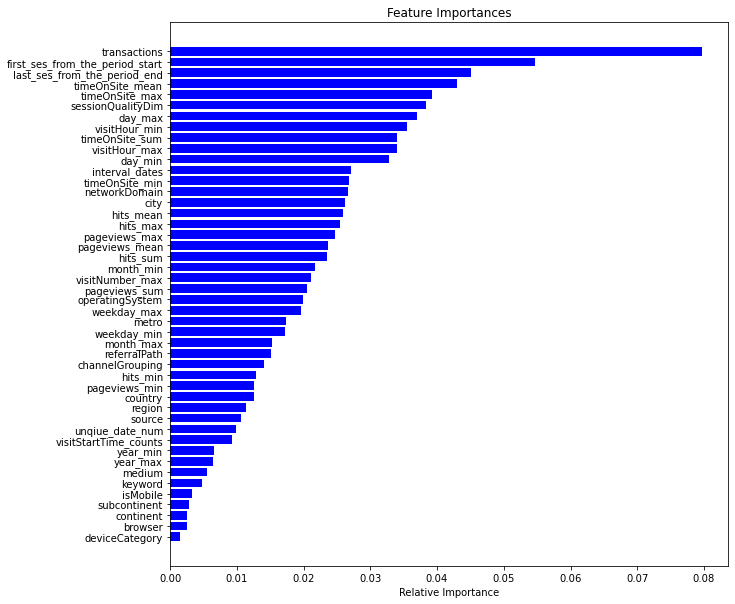

In [ ]:
features=train_df.drop(target_columns, axis=1).columns
importances = regressor.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [ ]:
len(indices)

46

In [ ]:
indices

array([12, 11, 13, 14, 39, 10,  9, 26, 25, 37, 45,  8,  4,  7, 30, 34,  5,
        6, 24, 19,  3, 20,  2, 29, 40, 23, 33, 32, 31, 35, 36,  1,  0, 16,
       44, 21, 28, 15, 27, 22, 38, 17, 18, 43, 42, 41])

In [ ]:
indices[:-5]

array([12, 11, 13, 14, 39, 10,  9, 26, 25, 37, 45,  8,  4,  7, 30, 34,  5,
        6, 24, 19,  3, 20,  2, 29, 40, 23, 33, 32, 31, 35, 36,  1,  0, 16,
       44, 21, 28, 15, 27, 22, 38])

In [ ]:
drop_feat = list(features[indices[:5]])

In [ ]:
drop_feat

['deviceCategory', 'browser', 'continent', 'subcontinent', 'isMobile']

In [ ]:
feature_imp_col = list(features[indices[5:]])

In [ ]:
X_train = train_df.drop(drop_feat, axis=1)

In [ ]:
X_train.shape

(1417575, 44)

In [ ]:
X_test = test_df.drop(drop_feat, axis=1)

In [ ]:
regressor  = RandomForestRegressor(n_estimators=1000)

In [ ]:
regressor.fit(X_train.drop(target_columns, axis=1)[X_train['is_returned']==1], X_train['revenue'][X_train['is_returned']==1])

RandomForestRegressor(n_estimators=1000)

In [ ]:
regressor_pred  = regressor.predict(X_test.drop(target_columns, axis=1))

Text(0.5, 0, 'Relative Importance')

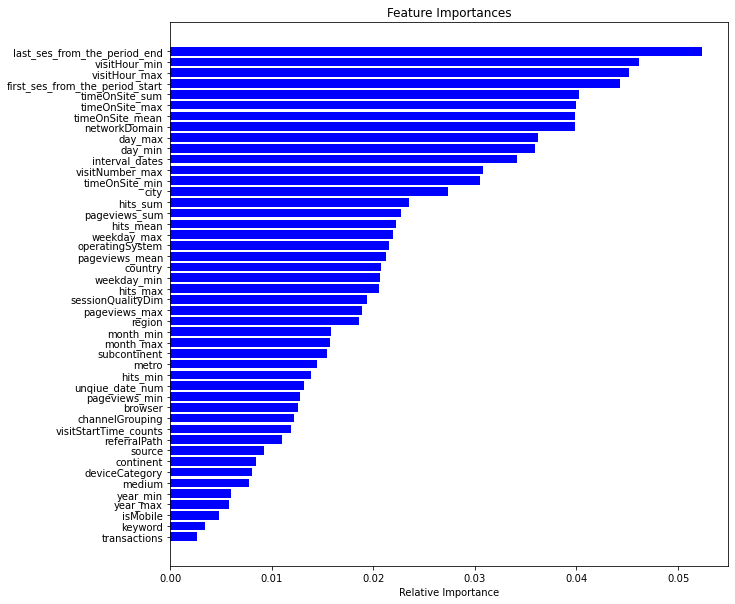

In [ ]:
features_c=train_df.drop(target_columns, axis=1).columns
importances_c = classifier.feature_importances_
indices_c = np.argsort(importances_c)

plt.figure(figsize=(10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices_c)), importances_c[indices_c], color='b', align='center')
plt.yticks(range(len(indices_c)), features_c[indices_c])
plt.xlabel('Relative Importance')

In [ ]:
drop_feat_c = list(features_c[indices_c[:5]])

In [ ]:
X_train_c = train_df.drop(drop_feat_c, axis=1)

In [ ]:
X_test_c = test_df.drop(drop_feat_c, axis=1)

In [ ]:
classifier  = RandomForestClassifier(n_estimators=200)

In [ ]:
classifier.fit(X_train_c.drop(target_columns, axis=1) , X_train_c['is_returned'])

RandomForestClassifier(n_estimators=200)

In [ ]:
classifier_pred = classifier.predict_proba(X_train_c.drop(target_columns, axis=1))[:,1]
regressor_pred  = regressor.predict(X_test_c.drop(target_columns, axis=1))

In [ ]:
classifier_predd = classifier.predict_proba(X_test_c.drop(target_columns, axis=1))[:,1]
regressor_predd  = regressor.predict(X_test_c.drop(target_columns, axis=1))

In [ ]:
predoo = classifier_predd*regressor_predd

In [ ]:
pred_df_new_date_f = pd.DataFrame({"fullVisitorId":X_test["fullVisitorId"].values})

pred_df_new_date_f["PredictedLogRevenue"] = predoo

pred_df_new_date_f.columns = ["fullVisitorId", "PredictedLogRevenue"]

In [ ]:
pred_df_new_date_f.to_csv("pred_rf_new_date_f.csv", index=False)

## Model:3 Logistic regression(for classification)+ Linear regression(for regression):

##### Logistic regression:

In [ ]:
target_columns = ['is_returned', 'revenue', 'fullVisitorId']

grid_params={'alpha':[10**-6,10**-5,10**-4,10**-3,10**-2,10**-1,1,10,100,1000,10000]}

model      = linear_model.SGDClassifier(loss="log", penalty="l2",class_weight='balanced')

gs         = GridSearchCV(model,grid_params,cv=3,scoring='roc_auc',verbose=2,n_jobs=-1)

gs_results = gs.fit(train_df.drop(target_columns, axis=1) , train_df['is_returned'])

print(gs_results.best_score_)
print(gs_results.best_params_)


Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:  7.4min finished


0.8355720706420215
{'alpha': 1e-06}


##### Linear regression:

In [ ]:
model=SGDRegressor(loss='squared_loss',penalty='l2')
alpha=[10**-4,10**-3,10**-2,10**-1,1,10,100]

param_grid={"alpha":alpha}

clf = GridSearchCV(model,param_grid, scoring = "neg_root_mean_squared_error", cv=3)
clf.fit(train_df.drop(target_columns, axis=1)[train_df['is_returned']==1], train_df['revenue'][train_df['is_returned']==1])

print(clf.best_params_)
print(gs_results.best_score_)

{'alpha': 0.001}
0.8355720706420215


In [ ]:
classifier      = linear_model.SGDClassifier(loss="log",alpha =0.000001, penalty="l2",class_weight='balanced')
regressor       = SGDRegressor(loss='squared_loss',alpha=0.001,penalty='l2')


classifier.fit(train_df.drop(target_columns, axis=1) , train_df['is_returned'])
regressor.fit(train_df.drop(target_columns, axis=1)[train_df['is_returned']==1], train_df['revenue'][train_df['is_returned']==1])


classifier_pred = classifier.predict_proba(test_df.drop(target_columns, axis=1))
regressor_pred  = regressor.predict(test_df.drop(target_columns, axis=1))
     
final_pred      = (classifier_pred[:,1]*regressor_pred)

In [ ]:
pred_df_time = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})

pred_df_time["PredictedLogRevenue"] = final_pred

pred_df_time.columns = ["fullVisitorId", "PredictedLogRevenue"]

In [ ]:
pred_df_time.to_csv("pred_linear_models1_time.csv", index=False)

In [ ]:
test_data = pd.read_csv('preprocessed_test_df_time.csv',dtype={'fullVisitorId': 'str'},index_col=0) 

test_data = test_data.groupby('fullVisitorId')[["totals.transactionRevenue"]].sum().apply(np.log1p, axis=1).reset_index()

In [ ]:
res = pd.merge(pred_df_time, test_data , left_on='fullVisitorId', right_on='fullVisitorId') 

rms = np.sqrt(mean_squared_error(res['totals.transactionRevenue'], res['PredictedLogRevenue']))

print(rms)

4.02350296845338e+16


<br>
<br>

 - <u>observations</u>:
  - so from the above models we observed that linear models (logistic and linear) are performing very poor and tree based models are performing highly accurate.
  - Both random forest and lightGBM are giving similar results.

_______________

<br>

## 7.Feature importance:

 - Here we will see which features are really useful., so that we will use only those features so that we can reduce the dimenssionality of data and computationl time also.

 - so for that we are using 'recursive feature elimination'
<br>
 
#####  <u>Recursive feature elimination:</u>
 - The recursive feature elimination idea is similar to backward feature selection.
 - First we need to specify the base model(Here base model has to return the feature importances). so that the algorithm first train the model on all features of the data set.
 - Now it will take feature importances of all features., Now by removing least importance feaures it will re-train the mdoel on new set of features., so this operation will iteratively run for different set of features.
 - Finally the feature set which is gibing best accuracy those features are selected as our final features.

https://towardsdatascience.com/feature-selection-in-python-recursive-feature-elimination-19f1c39b8d15
<br>
https://medium.com/@aneesha/recursive-feature-elimination-with-scikit-learn-3a2cbdf23fb7

## 9. Deep-learning models:

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.callbacks import ModelCheckpoint

from keras import optimizers

Using TensorFlow backend.


In [ ]:
target_columns = ['is_returned', 'revenue', 'fullVisitorId']

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.0003

In [ ]:
model_classification = Sequential()
model_classification.add(Dense(256, kernel_initializer='glorot_normal', activation='relu', input_dim=36))
model_classification.add(Dense(128, kernel_initializer='glorot_normal', activation='relu'))
model_classification.add(Dense(1,activation='sigmoid'))

In [ ]:
adam = optimizers.Adam(lr=LEARNING_RATE)
model_classification.compile(loss='binary_crossentropy', optimizer=adam)

In [ ]:
model_classification.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               9472      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 42,497
Trainable params: 42,497
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_classification.fit(x = train_df.drop(target_columns, axis=1) ,y=train_df['is_returned'],
                    batch_size=BATCH_SIZE, epochs=15, 
                    verbose=1)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [ ]:
model_regression = Sequential()
model_regression.add(Dense(256, kernel_initializer='glorot_normal', activation='relu', input_dim=36))
model_regression.add(Dense(128, kernel_initializer='glorot_normal', activation='relu'))
model_regression.add(Dense(1))

In [ ]:
adam = optimizers.adam(lr=LEARNING_RATE)
model_regression.compile(loss='mse', optimizer=adam)

In [ ]:
model_regression.summary()

In [ ]:
history = model_regression.fit(x=train_df.drop(target_columns, axis=1)[train_df['is_returned']==1], y= train_df['revenue'][train_df['is_returned']==1],
                    batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    verbose=1)

In [ ]:
classification_predictions = model_classification.predict(test_df.drop(target_columns, axis=1))

regression_predictions     = model_regression.predict(test_df.drop(target_columns, axis=1))
regression_predictions[regression_predictions<0] = 0


val_predictions = classification_predictions*regression_predictions

In [ ]:
pred_df = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})

pred_df["PredictedLogRevenue"] = val_predictions

pred_df.columns = ["fullVisitorId", "PredictedLogRevenue"]


In [ ]:
test_data = pd.read_csv('/content/drive/My Drive/for_final.csv',dtype={'fullVisitorId': 'str'})

In [ ]:
res = pd.merge(pred_df, test_data , left_on='fullVisitorId', right_on='fullVisitorId') 

rms = np.sqrt(mean_squared_error(res['totals.transactionRevenue'], res['PredictedLogRevenue']))


In [ ]:
print('Model validation metrics')
print('RMSE: %.2f' % rms)

In [ ]:
pred_df.to_csv('mlp_model_1.csv',index=False)

## 9.1 CNN model:

In [ ]:
# https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

#samples= n 
#input_time_steps = d
#ouput_time_steps = 1(output variable)

### 9.1.1 Building classification model:

In [ ]:
n_features = 1
n_steps    = 36
BATCH_SIZE = 64

In [ ]:
# code refrence from live session of applied ai

tf.keras.backend.clear_session()  # For easy reset of notebook state.

checkpoint_path = "cnn_classification_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [ ]:
train = train_df.drop(target_columns, axis=1)

In [ ]:
train.shape

In [ ]:
train = train.values.reshape((train.shape[0], train.shape[1], n_features))
train.shape

In [ ]:
classification_model = keras.Sequential([
                                         keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)),
                                         keras.layers.MaxPooling1D(pool_size=2),
                                         keras.layers.Flatten(),
                                         keras.layers.Dense(50, activation='relu'),
                                         keras.layers.Dense(1,activation='sigmoid')
                                         ])

classification_model.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
classification_model.summary()

In [ ]:
# https://stackoverflow.com/questions/58636087/tensorflow-valueerror-failed-to-convert-a-numpy-array-to-a-tensor-unsupporte

classification_model.fit(x = np.asarray(train).astype(np.float32) ,y=train_df['is_returned'],
                    batch_size=64, epochs=20,callbacks=[cp_callback])

### 9.1.2 Building regression model :

In [ ]:
n_features = 1
n_steps    = 36
BATCH_SIZE = 64

In [ ]:
# code refrence from live session of applied ai

tf.keras.backend.clear_session()  # For easy reset of notebook state.

checkpoint_path = "cnn_regression_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [ ]:
train = train_df.drop(target_columns, axis=1)[train_df['is_returned']==1]

In [ ]:
train = train.values.reshape((train.shape[0], train.shape[1], n_features))
train.shape

In [ ]:
regression_model = keras.Sequential([
                                         keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)),
                                         keras.layers.MaxPooling1D(pool_size=2),
                                         keras.layers.Flatten(),
                                         keras.layers.Dense(50, activation='relu'),
                                         keras.layers.Dense(1,activation='sigmoid')
                                         ])

regression_model.compile(optimizer='adam', loss='mse')

In [ ]:
regression_model.summary()

In [ ]:
regression_model.fit(x = np.asarray(train).astype(np.float32) ,y=train_df['revenue'][train_df['is_returned']==1],
                    batch_size=64, epochs=20,callbacks=[cp_callback])

### 9.1.3 Final model:

In [ ]:
test = test_df.drop(target_columns, axis=1)
test = test.values.reshape((test.shape[0], test.shape[1], n_features))


classification_predictions = classification_model.predict(np.asarray(test).astype(np.float32))


regression_predictions     = regression_model.predict(np.asarray(test).astype(np.float32))
regression_predictions[regression_predictions<0] = 0


val_predictions = classification_predictions*regression_predictions

In [ ]:
pred_df = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})

pred_df["PredictedLogRevenue"] = val_predictions

pred_df.columns = ["fullVisitorId", "PredictedLogRevenue"]


In [ ]:
test_data = pd.read_csv('/content/drive/My Drive/for_final.csv',dtype={'fullVisitorId': 'str'})

In [ ]:
res = pd.merge(pred_df, test_data , left_on='fullVisitorId', right_on='fullVisitorId') 

rms = np.sqrt(mean_squared_error(res['totals.transactionRevenue'], res['PredictedLogRevenue']))


In [ ]:
print('Model validation metrics')
print('RMSE: %.2f' % rms)

In [ ]:
pred_df.to_csv('cnn_model_predictions.csv',index=False)

## 10.conclusions and results:

 - Here we are using simple mlp and cnn architectures for our data.
 - Results are not significantly better., but deep learning models are also giving good score as tree based models.

In [ ]:
x = PrettyTable()

x.field_names = ["s.no","sub models", "RMSE(our calculation)","kaggle leaderboard private score"]


x.add_row(["Model-1:"," "," "," "])
print('\n')
x.add_row(["","MLP model Classification (with binary_crossentropy = 0.0310)","_","_"])
x.add_row(["","MLP model Regression     (with mse = 56.5816)","_","_"])
x.add_row(["","Final model","2.10","0.88561"])

x.add_row([" "," "," "," "])
x.add_row(["Model-2:"," "," "," "])
print('\n')
x.add_row(["","CNN model Classification (with binary_crossentropy = 0.0302)","_","_"])
x.add_row(["","CNN model Regression     (with mse = 18.9295)","_","_"])
x.add_row(["","Final model","2.11","0.88843"])

print(x)


In [ ]:
from IPython.display import Image
Image(filename="/content/Screenshot (104).png")

## 11. changing  model architecture:


 - debugging why train accuracy not changing
 - we are dividing our train data 70 and 30 % and checking with various architectures.

In [ ]:
print("train data no.of points: ",train_df.shape[0])
print("80% of data points: " ,0.7*train_df.shape[0])
print("20% of data points: " ,0.3*train_df.shape[0])

In [ ]:
train_sample = train_df[:992302]
validation_sample  = train_df[992301:] 

In [ ]:
target_columns = ['is_returned', 'revenue', 'fullVisitorId']

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.0003

### Buidling classification model:

In [ ]:
import datetime
tf.keras.backend.clear_session()  # For easy reset of notebook state.

! rm -rf ./logs/ 
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
%tensorboard --logdir $logdir

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model_classification = keras.Sequential([
                                          keras.layers.Dense(256, kernel_initializer='glorot_normal', activation='relu', input_dim=36),
                                          keras.layers.Dropout(0.4),

                                          keras.layers.Dense(128, kernel_initializer='glorot_normal', activation='relu'),
                                          keras.layers.Dropout(0.3),
                                          
                                          keras.layers.Dense(64, kernel_initializer='glorot_normal', activation='relu'),
                                          keras.layers.BatchNormalization(),
                                          keras.layers.Dropout(0.2),
                                         
                                          keras.layers.Dense(16, kernel_initializer='glorot_normal', activation='relu'),
                                         
                                          keras.layers.Dense(1,activation='sigmoid')
                                          ])

model_classification.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

history = model_classification.fit(x =  np.asarray(train_sample.drop(target_columns, axis=1)).astype(np.float32) ,y=train_sample['is_returned'],
                                   validation_data= ( np.asarray(validation_sample.drop(target_columns, axis=1)).astype(np.float32) ,validation_sample['is_returned']),
                                   batch_size=BATCH_SIZE, epochs=10,callbacks = [tensorboard_callback] ,
                                   )

In [ ]:
from IPython.display import Image
Image(filename="Screenshot (108).png")


In [ ]:
Image(filename="Screenshot (109).png")

### Building regression model:

In [ ]:
import datetime
tf.keras.backend.clear_session()  # For easy reset of notebook state.

! rm -rf ./logs/ 
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
%tensorboard --logdir $logdir

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model_regression = keras.Sequential([
                                          keras.layers.Dense(256, kernel_initializer='glorot_normal', activation='relu', input_dim=36),
                                          keras.layers.Dropout(0.4),

                                          keras.layers.Dense(128, kernel_initializer='glorot_normal', activation='relu'),
                                          keras.layers.Dropout(0.3),
                                          
                                          keras.layers.Dense(64, kernel_initializer='glorot_normal', activation='relu'),                                          
                                          keras.layers.Dropout(0.2),
                                         
                                          keras.layers.Dense(16, kernel_initializer='glorot_normal', activation='relu'),
                                         
                                          keras.layers.Dense(1)
                                          ])

adam = optimizers.adam(lr=1e-2, decay=0.001)

model_regression.compile(loss='mse', optimizer='adam',metrics=['MeanSquaredError'])


history = model_regression.fit(x =  np.asarray(train_sample.drop(target_columns, axis=1)[train_sample['is_returned']==1]).astype(np.float32) ,
                               y =  train_sample['revenue'][train_sample['is_returned']==1],
                              validation_data= ( np.asarray(validation_sample.drop(target_columns, axis=1)[validation_sample['is_returned']==1]).astype(np.float32) ,validation_sample['revenue'][validation_sample['is_returned']==1]),
                              batch_size=BATCH_SIZE, epochs=100,callbacks = [tensorboard_callback] ,
                              )

In [ ]:
Image(filename="Screenshot (110).png")

### Building final model:

In [ ]:



classification_predictions = model_classification.predict(np.asarray(test_df.drop(target_columns, axis=1)).astype(np.float32) )

regression_predictions     = model_regression.predict(np.asarray(test_df.drop(target_columns, axis=1)).astype(np.float32) )
regression_predictions[regression_predictions<0] = 0


val_predictions = classification_predictions*regression_predictions

In [ ]:
pred_df = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})

pred_df["PredictedLogRevenue"] = val_predictions

pred_df.columns = ["fullVisitorId", "PredictedLogRevenue"]


In [ ]:
test_data = pd.read_csv('/content/drive/My Drive/for_final.csv',dtype={'fullVisitorId': 'str'})

In [ ]:
res = pd.merge(pred_df, test_data , left_on='fullVisitorId', right_on='fullVisitorId') 

rms = np.sqrt(mean_squared_error(res['totals.transactionRevenue'], res['PredictedLogRevenue']))


In [ ]:
print('Model validation metrics')
print('RMSE: %.2f' % rms)

## 12. Ensemble Models:

https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205
<br>

https://machinelearningmastery.com/implement-bagging-scratch-python/

##### Ensemble architecture:

In [ ]:
Image(filename="Ensemble_case_study.png")

In [ ]:
print(train_df.shape)
print(test_df.shape)

target_columns = ['is_returned', 'revenue', 'fullVisitorId']

In [ ]:
# Create a random subsample from the dataset with replacement
def subsample(dataset, ratio=1.0):
    sample = list()
    n_sample = round(len(dataset) * ratio)
    while len(sample) < n_sample:
        index = randrange(len(dataset))
        sample.append(dataset.iloc[index])
    return sample

In [ ]:
sample_1    = subsample(train_df)
sample_1_df = pd.DataFrame(np.array(sample_1).reshape(1417575,39), columns = list(train_df.columns))

sample_2    = subsample(train_df)
sample_2_df = pd.DataFrame(np.array(sample_2).reshape(1417575,39), columns = list(train_df.columns))

sample_3    = subsample(train_df)
sample_3_df = pd.DataFrame(np.array(sample_3).reshape(1417575,39), columns = list(train_df.columns))


In [ ]:
#sample_1_df.to_csv("sample_1_df.csv")
#sample_2_df.to_csv("sample_2_df.csv")
#sample_3_df.to_csv("sample_3_df.csv")

sample_1_df = pd.read_csv('sample_1_df.csv',dtype={'fullVisitorId': 'str'},index_col=0)
sample_2_df = pd.read_csv('sample_2_df.csv',dtype={'fullVisitorId': 'str'},index_col=0)
sample_3_df = pd.read_csv('sample_3_df.csv',dtype={'fullVisitorId': 'str'},index_col=0)

In [ ]:
target_columns = ['is_returned', 'revenue', 'fullVisitorId']

<svg width="400" height="110">
  <rect width="300" height="100" style="fill:rgb(0,0,255);stroke-width:3;stroke:rgb(0,0,0)" />
</svg>

#### Building Model 1 : Random-forest regressor:

 - Hyperparameter tuning:

In [ ]:
sample_1_df = pd.read_csv('sample_1_df.csv',dtype={'fullVisitorId': 'str'},index_col=0)

In [ ]:
gridParams = {"n_estimators":[200,400,600,800,1000],
              "max_depth": [2,5,7,9,10],
              "min_samples_split":[2,3,5,7],
              "min_samples_leaf": [1,2,4],
              "max_features": ['auto', 'sqrt'],
             }

# initalizig model object

regressor = RandomForestRegressor()


# RandomizedSearchCV to hypertune the parameters

random_search = RandomizedSearchCV(regressor, 
                                   gridParams,
                                   cv=3,verbose=10,n_jobs=-1)


# Run the Randomsearch cv on the train dataset to find tuned hyperparameters
x = sample_1_df.drop(target_columns, axis=1)
y = sample_1_df['revenue']

%time random_search.fit(x,y)




In [ ]:
print(random_search.best_params_)
print(random_search.best_score_)

#### Building Model 2 : LGB regressor:

 - Hyperparameter-tuning:

In [ ]:
sample_2_df = pd.read_csv('sample_2_df.csv',dtype={'fullVisitorId': 'str'},index_col=0)

In [ ]:
gridParams = {
    'learning_rate': [0.005,0.01,0.015],   #Learning rate
    'n_estimators': [40,100,200],          #number of boosting iterations   
    'num_leaves': [6,8,12,15,16],          #number of leaves in full tree
    'boosting_type' : ['gbdt'],
    'objective' : ['regression'],          #Regression model to predict transaction amount
    'metric' : ['rmse'],                   #Performance metric as "RMSE
    'colsample_bytree' : [0.6, 0.8, 1],    #LightGBM will select 80% of features before training each tree
    'subsample' : [0.7,0.9, 1],            #this will randomly select part of data without resampling
    'reg_alpha' : [0,1],                   #L1 regularization
    'reg_lambda' : [0,1],                  #L2 regularization
    'max_leaves': [128,256,512],           #Maximum number of nodes to be added. 
    'min_child_samples' : [1,20]           #Minimum number of data points needed in a child (leaf) node.   
    }


# Define LightGBM Regressor model

model = lgb.LGBMRegressor()

# RandomizedSearchCV to hypertune the parameters

random_search = RandomizedSearchCV(model,
                                   gridParams,
                                   cv=3)

# Run the Randomsearch cv on the train dataset to find tuned hyperparameters

%time random_search.fit(sample_2_df.drop(target_columns, axis=1), sample_2_df['revenue'])


# Print the best parameters found

print(random_search.best_params_)
print(random_search.best_score_)

### Model 3: XGB Regressor:

 - Hyperparameter tuning:

In [ ]:
sample_3_df = pd.read_csv('sample_3_df.csv',dtype={'fullVisitorId': 'str'},index_col=0)

In [ ]:
gridParams = {"n_estimators":[10,50,100,200,300,600,800,1000],
              "max_depth": [2,5,7,9,10],
              "subsample":[0.7, 0.8, 0.9],
              "min_child_weight":[3, 5, 7]              
              }


# Define XGB Regressor model:

regressor = xgb.XGBRegressor()

# RandomizedSearchCV to hypertune the parameters:

random_search = RandomizedSearchCV(regressor,
                                   gridParams,
                                   scoring="neg_root_mean_squared_error",
                                   cv=3,verbose=20)


# Run the Randomsearch cv on the train dataset to find tuned hyperparameters

%time random_search.fit(sample_3_df.drop(target_columns, axis=1), sample_3_df['revenue'])


 - It will take hours to run ,so I trained it on gpu by using "regressor = xgb.XGBRegressor(tree_method='gpu_hist')"

In [ ]:
# Print the best parameters found

print(random_search.best_params_)
print(random_search.best_score_)

### Final Ensemble Model:

In [ ]:
sample_1_df = pd.read_csv('sample_1_df.csv',dtype={'fullVisitorId': 'str'},index_col=0)
sample_2_df = pd.read_csv('sample_2_df.csv',dtype={'fullVisitorId': 'str'},index_col=0)
sample_3_df = pd.read_csv('sample_3_df.csv',dtype={'fullVisitorId': 'str'},index_col=0)

In [ ]:
target_columns = ['is_returned', 'revenue', 'fullVisitorId']

#### Training model -1 on best hyperparameter values:

In [ ]:
sample_1_df = pd.read_csv('sample_1_df.csv',dtype={'fullVisitorId': 'str'},index_col=0)

In [ ]:
regressor_1  = RandomForestRegressor(n_estimators     = 400, min_samples_split = 5, 
                                     min_samples_leaf = 2  , max_features      ='auto', 
                                     max_depth        = 10 ,  n_jobs=-1)

regressor_1.fit(sample_1_df.drop(target_columns, axis=1),sample_1_df['revenue'])

####  Training model-2 on best hyperparameter values:

In [ ]:
sample_2_df = pd.read_csv('sample_2_df.csv',dtype={'fullVisitorId': 'str'},index_col=0)

In [ ]:
params_lgb = {'subsample': 0.9, 
              'reg_lambda': 0, 
              'reg_alpha': 1, 
              'objective': 'regression',
              'num_leaves': 16, 
              'n_estimators': 200, 
              'min_child_samples': 20, 
              'metric': 'rmse', 
              'max_leaves': 128, 
              'learning_rate': 0.005, 
              'colsample_bytree': 1,
              'boosting_type': 'gbdt'}

dtrain = lgb.Dataset(sample_2_df.drop(target_columns, axis=1),sample_2_df['revenue'])

regressor_2 = lgb.train(params_lgb, dtrain)

####  Training model-3 on best hyperparameter values:

In [ ]:
sample_3_df = pd.read_csv('sample_3_df.csv',dtype={'fullVisitorId': 'str'},index_col=0)

In [ ]:
regressor_3  = xgb.XGBRegressor(subsample = 0.7, n_estimators = 1000, min_child_weight= 7, max_depth = 10,n_jobs=-1)

regressor_3.fit(sample_3_df.drop(target_columns, axis=1),sample_3_df['revenue'])

#### predicting on test data:

In [ ]:
regressor_1_pred                     = regressor_1.predict(test_df.drop(target_columns, axis=1))
pred_df_reg_1                        = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})
pred_df_reg_1["PredictedLogRevenue"] = regressor_1_pred
pred_df_reg_1.columns                = ["fullVisitorId", "PredictedLogRevenue"]

pred_df_reg_1.to_csv('pred_df_reg_1.csv',index=False)

#---------------------------------------------------------------------------------------------

regressor_2_pred                     = regressor_2.predict(test_df.drop(target_columns, axis=1))
pred_df_reg_2                        = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})
pred_df_reg_2["PredictedLogRevenue"] = regressor_2_pred
pred_df_reg_2.columns                = ["fullVisitorId", "PredictedLogRevenue"]

pred_df_reg_2.to_csv('pred_df_reg_2.csv',index=False)

#---------------------------------------------------------------------------------------------

regressor_3_pred                     = regressor_3.predict(test_df.drop(target_columns, axis=1))
pred_df_reg_3                        = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})
pred_df_reg_3["PredictedLogRevenue"] = regressor_3_pred
pred_df_reg_3.columns                = ["fullVisitorId", "PredictedLogRevenue"]

pred_df_reg_3.to_csv('pred_df_reg_3.csv',index=False)

#---------------------------------------------------------------------------------------------



In [ ]:
# reading csv files of output of 3 models:

pred_df_reg_1 = pd.read_csv('pred_df_reg_1.csv',dtype={'fullVisitorId': 'str'},index_col=0) 
pred_df_reg_2 = pd.read_csv('pred_df_reg_2.csv',dtype={'fullVisitorId': 'str'},index_col=0) 
pred_df_reg_3 = pd.read_csv('pred_df_reg_3.csv',dtype={'fullVisitorId': 'str'},index_col=0) 


# merging all 3 results and taking average:
final_ensemble_pred = pred_df_reg_1.merge(pred_df_reg_2, on='fullVisitorId').merge(pred_df_reg_3,on='fullVisitorId') 

final_ensemble_pred['mean'] = final_ensemble_pred.mean(axis=1)

# making zero if mean is negative:
final_ensemble_pred['mean'][final_ensemble_pred['mean'] < 0] = 0

final_ensemble_pred = final_ensemble_pred.reset_index()
final_ensemble_pred = final_ensemble_pred[['fullVisitorId','mean']]
final_ensemble_pred.columns = ['fullVisitorId', 'PredictedLogRevenue']


In [ ]:
final_ensemble_pred.to_csv('final_ensemble_pred.csv',index = False)

In [ ]:
Image(filename="Screenshot (111).png")

##### conclusion:
 - By using Ensemble model for regression we are getting top 5 % solution on kaggle leader board.